**This is a NLP problem where the task is to classify Fake News in an article. This notebook consists of various stages needed for identifying fake news such as data preprocessing, model experimentation, and evaluation of results.**

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
# nltk.download('stopwords')
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU
from tensorflow.keras.layers import Dense

In [2]:
# Reading data from csv
train = pd.read_csv("fake-news/train.csv")
test  = pd.read_csv("fake-news/test.csv")
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [4]:
# Displaying rows and columns in dataset
print("There are {} number of rows and {} number of columns for training.".format(train.shape[0],train.shape[1]))
print("There are {} number of rows and {} number of columns for testing.".format(test.shape[0],test.shape[1]))

There are 20800 number of rows and 5 number of columns for training.
There are 5200 number of rows and 4 number of columns for testing.


**Checking Null Values**

In [5]:
# Checking the null values in training data.
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
# Checking the null values in testing data.
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [7]:
# Handling nan values in dataset using empty spaces
def handle_nan(train_data,test_data):
    '''Input: Data to the function containing Nan values.
       Output : Cleaned data containing no Nan values.
       Function: Cleaning Nan values.
     '''
    train = train_data.fillna(" ")
    test  = test_data.fillna(" ")
    return train,test

train,test = handle_nan(train,test)


In [8]:
# Creating a variable "merged" by merging columns "title" and "author"
train["merged"] = train["title"]+" "+ train["author"]
test["merged"]  = test["title"]+" "+ test["author"]

In [9]:
# Seperating Independent and dependent features
X = train.drop(columns=['label'],axis=1)
y = train['label']

In [10]:
# Creating One-Hot Representations
messages = X.copy()
messages.reset_index(inplace=True)
messages_test = test.copy()
messages_test.reset_index(inplace=True)

In [11]:
messages["text"][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [12]:
messages.head()

,index,id,title,author,text,merged
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Why the Truth Might Get You Fired Consortiumne...
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,15 Civilians Killed In Single US Airstrike Hav...
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,Iranian woman jailed for fictional unpublished...


In [13]:
messages_test.head()

,index,id,title,author,text,merged
0,0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...","Specter of Trump Loosens Tongues, if Not Purse..."
1,1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...,Russian warships ready to strike terrorists ne...
2,2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,#NoDAPL: Native American Leaders Vow to Stay A...
3,3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...","Tim Tebow Will Attempt Another Comeback, This ..."
4,4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Keiser Report: Meme Wars (E995) Truth Broadcas...


# Data Pre-processing
**In Data Pre-processing following steps are followed:** 
**1. Firstly, all the sequences except english characters are removed from the string.**
**2. Next, to avoid false predictions or ambiguity with upper and lowercase, all the characters in strings are converted    to lowercase.**
**3. Next, all the sentences are tokenized into words.**
**4. To facilitate fast processing, stemming is applied to the tokenized words.**
**5. Next, words are joined together and stored in the corpus.**

**Note: In this tutorial, we have used "merged" column for classification task. Also, the loop inside the function runs over all the examples in the merged column.**

In [14]:
# Performing data preprocessing on column 'title'
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def perform_preprocess(data):
    '''Input: Data to be processed
       Output: Preprocessed data
    '''
    corpus = []
    for i in range(0,len(data)):
        review = re.sub('[^a-zA-Z]',' ',data['merged'][i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    return corpus
    
train_corpus = perform_preprocess(messages)
test_corpus  = perform_preprocess(messages_test)
train_corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn'

In [15]:
test_corpus[1]

'russian warship readi strike terrorist near aleppo'

**Below code converts the pre-processed words to one-hot vectors in the range of vocabulary size=5000. This is done to obtain numerical feature matrix**

In [16]:
# Converting to one-hot repr.
vocab_size = 5000
one_hot_train = [one_hot(word,vocab_size) for word in train_corpus]
one_hot_test  = [one_hot(word,vocab_size) for word in test_corpus]

In [17]:
one_hot_test[1]

[2493, 912, 3291, 4324, 35, 254, 1190]

**Below code creates an embedding layer which applies "pre" padding to the one-hot encoded features with sentence length = 20. Padding is applied so that the length of every sequence in the dataset should be same.**

In [18]:
# Embedding Representation 
sent_length = 20
embedd_docs_train = pad_sequences(one_hot_train,padding='pre',maxlen=sent_length)
embedd_docs_test  = pad_sequences(one_hot_test,padding='pre',maxlen=sent_length)
print(embedd_docs_train)

[[   0    0    0 ... 4386 4791 3048]
 [   0    0    0 ...  144 2731 2331]
 [   0    0    0 ... 1358   57 4698]
 ...
 [   0    0    0 ... 2199 2993  356]
 [   0    0    0 ... 4192 2101 1198]
 [   0    0    0 ...   82 4976 1921]]


In [19]:
embedd_docs_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0, 4767, 2711, 3983,
       1191,  860, 3248, 1718, 3205, 3143, 4386, 4791, 3048])

In [20]:
print(embedd_docs_test)

[[   0    0    0 ... 2646 4976 1594]
 [   0    0    0 ...   35  254 1190]
 [   0    0    0 ... 2104  745 1946]
 ...
 [   0    0    0 ... 2646 4681 1992]
 [   0    0    0 ... 2493 2047 1428]
 [   0    0    0 ... 2646 2463 4797]]


In [21]:
# Converting Embedding repr. to array
x_final = np.array(embedd_docs_train)
y_final = np.array(y)
x_test_final = np.array(embedd_docs_test)

In [22]:
# Dimensions of prev. array repr.
x_final.shape,y_final.shape,x_test_final.shape

((20800, 20), (20800,), (5200, 20))

**Dividing the dataset into training,validation and testing data (ratio: 80/10/10) using train_test_split technique.**

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42, stratify = y_final)
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify = y_train)
x_test_final = x_test_final

# Creating Models
**In this phase, several models are created and evaluated against various metrics shown using classification report.**

## Baseline Models

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [25]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Naive Bayes": MultinomialNB(),
          "Decision Tree Classifier": DecisionTreeClassifier(),
          "XGBoost Classifier": XGBClassifier(),
          "CatBoost Classifier": CatBoostClassifier(iterations=150)}

# Create a function to fit and score models
def fit_and_score(models, X_train, x_test, Y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learn Machine Learning models
    X_train: Training data (no labels)
    X_test: Testing data (no labels)
    y_train: Training labels
    y_test: Test labels
    """
    
    # Set random seed
    np.random.seed(12)
    
    # Make a dictionary to keep model scores
    model_scores = {}
    
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, Y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(x_test, y_test)
        
    return model_scores

In [26]:
model_scores = fit_and_score(models=models, X_train=X_train, x_test=x_test, Y_train=Y_train, y_test=y_test)
model_scores

C:\Users\khand\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Learning rate set to 0.195972
0:	learn: 0.5536498	total: 189ms	remaining: 28.2s
1:	learn: 0.4836737	total: 200ms	remaining: 14.8s
2:	learn: 0.4422848	total: 212ms	remaining: 10.4s
3:	learn: 0.3873730	total: 223ms	remaining: 8.13s
4:	learn: 0.3630892	total: 234ms	remaining: 6.77s
5:	learn: 0.3504267	total: 245ms	remaining: 5.88s
6:	learn: 0.3402142	total: 256ms	remaining: 5.22s
7:	learn: 0.3291282	total: 265ms	remaining: 4.7s
8:	learn: 0.3173524	total: 275ms	remaining: 4.3s
9:	learn: 0.3066484	total: 285ms	remaining: 4s
10:	learn: 0.3012964	total: 296ms	remaining: 3.74s
11:	learn: 0.2951128	total: 306ms	remaining: 3.52s
12:	learn: 0.2884699	total: 317ms	remaining: 3.34s
13:	learn: 0.2840047	total: 327ms	remaining: 3.18s
14:	learn: 0.2786991	total: 338ms	remaining: 3.04s
15:	learn: 0.2735621	total: 348ms	remaining: 2.92s
16:	learn: 0.2631669	total: 358ms	remaining: 2.8s
17:	learn: 0.2586072	total: 367ms	remaining: 2.69s
18:	learn: 0.2548148	total: 377ms	remaining: 2.6s
19:	learn: 0.25287

{'Logistic Regression': 0.6889423076923077,
 'KNN': 0.7524038461538461,
 'Random Forest': 0.9201923076923076,
 'Naive Bayes': 0.6721153846153847,
 'Decision Tree Classifier': 0.89375,
 'XGBoost Classifier': 0.9076923076923077,
 'CatBoost Classifier': 0.9725961538461538}

**1. Logistic Regresssion**

In [27]:
model_1 = LogisticRegression(max_iter=150)
model_1.fit(X_train,Y_train)
pred_1 = model_1.predict(x_test)
cr1    = classification_report(y_test,pred_1)
print(cr1)

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1039
           1       0.70      0.66      0.67      1041

    accuracy                           0.68      2080
   macro avg       0.68      0.68      0.68      2080
weighted avg       0.68      0.68      0.68      2080



C:\Users\khand\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**2. Naive Bayes**

In [28]:
model_2 = MultinomialNB()
model_2.fit(X_train,Y_train)
pred_2 = model_2.predict(x_test)
cr2    = classification_report(y_test,pred_2)
print(cr2)

              precision    recall  f1-score   support

           0       0.70      0.61      0.65      1039
           1       0.65      0.74      0.69      1041

    accuracy                           0.67      2080
   macro avg       0.68      0.67      0.67      2080
weighted avg       0.68      0.67      0.67      2080



**3. Decision Trees**

In [29]:
model_3 = DecisionTreeClassifier()
model_3.fit(X_train,Y_train)
pred_3 = model_3.predict(x_test)
cr3    = classification_report(y_test,pred_3)
print(cr3)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1039
           1       0.91      0.89      0.90      1041

    accuracy                           0.90      2080
   macro avg       0.90      0.90      0.90      2080
weighted avg       0.90      0.90      0.90      2080



**4. Random Forest**

In [30]:
model_4 = RandomForestClassifier()
model_4.fit(X_train,Y_train)
pred_4 = model_4.predict(x_test)
cr4    = classification_report(y_test,pred_4)
print(cr4)

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1039
           1       0.88      0.96      0.92      1041

    accuracy                           0.91      2080
   macro avg       0.92      0.91      0.91      2080
weighted avg       0.92      0.91      0.91      2080



**5. XGBOOST**

In [31]:
model_5 = XGBClassifier()
model_5.fit(X_train,Y_train)
pred_5 = model_5.predict(x_test)
cr5    = classification_report(y_test,pred_5)
print(cr5)

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1039
           1       0.87      0.96      0.91      1041

    accuracy                           0.91      2080
   macro avg       0.91      0.91      0.91      2080
weighted avg       0.91      0.91      0.91      2080



**6.Catboost**

In [33]:
model_6 = CatBoostClassifier(iterations=150)
model_6.fit(X_train,Y_train)
pred_6 = model_5.predict(x_test)
cr6    = classification_report(y_test,pred_5)
print(cr6)

Learning rate set to 0.195972
0:	learn: 0.5536498	total: 18.5ms	remaining: 2.75s
1:	learn: 0.4836737	total: 30.1ms	remaining: 2.22s
2:	learn: 0.4422848	total: 41.4ms	remaining: 2.03s
3:	learn: 0.3873730	total: 52.5ms	remaining: 1.92s
4:	learn: 0.3630892	total: 63.9ms	remaining: 1.85s
5:	learn: 0.3504267	total: 75ms	remaining: 1.8s
6:	learn: 0.3402142	total: 86.7ms	remaining: 1.77s
7:	learn: 0.3291282	total: 96.6ms	remaining: 1.72s
8:	learn: 0.3173524	total: 108ms	remaining: 1.69s
9:	learn: 0.3066484	total: 119ms	remaining: 1.67s
10:	learn: 0.3012964	total: 130ms	remaining: 1.65s
11:	learn: 0.2951128	total: 141ms	remaining: 1.62s
12:	learn: 0.2884699	total: 151ms	remaining: 1.59s
13:	learn: 0.2840047	total: 162ms	remaining: 1.57s
14:	learn: 0.2786991	total: 173ms	remaining: 1.55s
15:	learn: 0.2735621	total: 185ms	remaining: 1.55s
16:	learn: 0.2631669	total: 197ms	remaining: 1.54s
17:	learn: 0.2586072	total: 207ms	remaining: 1.52s
18:	learn: 0.2548148	total: 218ms	remaining: 1.5s
19:	lea

**7. LSTM**

**In this model, 1.) The value for embedding feature vectors = 40 which are target feature vectors for the embedding layer. 2.) Single LSTM Layer with 100 nodes are used. 3.)Dense Layer with 1 neuron and sigmoid activation function is used since, this is a binary classification problem. 4) Dropout technique is used to avoid overfiiting and adam optimizer is used for optimizing the loss function.**

In [34]:
# Creating the LSTM Model for prediction
embedding_feature_vector = 40
model = Sequential()
model.add(Embedding(vocab_size,embedding_feature_vector,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
# Training the model
model.fit(X_train,Y_train,validation_data=(x_valid,y_valid),epochs=10,batch_size=64)

Epoch 1/10
264/264 [==============================] - 7s 20ms/step - loss: 0.3779 - accuracy: 0.8152 - val_loss: 0.0304 - val_accuracy: 0.9947
Epoch 2/10
264/264 [==============================] - 4s 17ms/step - loss: 0.0262 - accuracy: 0.9924 - val_loss: 0.0228 - val_accuracy: 0.9947
Epoch 3/10
264/264 [==============================] - 4s 16ms/step - loss: 0.0110 - accuracy: 0.9972 - val_loss: 0.0192 - val_accuracy: 0.9957
Epoch 4/10
264/264 [==============================] - 4s 16ms/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 0.0181 - val_accuracy: 0.9957
Epoch 5/10
264/264 [==============================] - 4s 16ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0180 - val_accuracy: 0.9963
Epoch 6/10
264/264 [==============================] - 4s 17ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0345 - val_accuracy: 0.9915
Epoch 7/10
264/264 [==============================] - 4s 16ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0262 - val_accuracy: 0.9915

In [36]:
predictions = model.predict_classes(x_test)
cr = classification_report(y_test,predictions)
print(cr)

C:\Users\khand\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1039
           1       1.00      0.99      0.99      1041

    accuracy                           0.99      2080
   macro avg       0.99      0.99      0.99      2080
weighted avg       0.99      0.99      0.99      2080



In [37]:
model_compare = pd.DataFrame(model_scores, index=["Accuracy"])
model_compare

,Logistic Regression,KNN,Random Forest,Naive Bayes,Decision Tree Classifier,XGBoost Classifier,CatBoost Classifier
Accuracy,0.688942,0.752404,0.920192,0.672115,0.89375,0.907692,0.972596


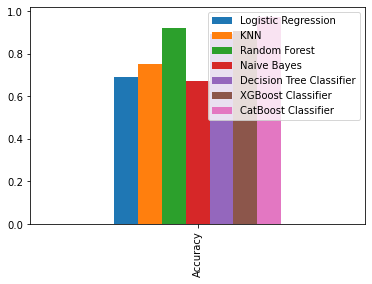

In [39]:
model_compare.plot(kind="bar");

# Evaluation of Models

**Tabulating the results of various implemented models.**

In [40]:
score_1 = accuracy_score(y_test,pred_1)
score_2 = accuracy_score(y_test,pred_2)
score_3 = accuracy_score(y_test,pred_3)
score_4 = accuracy_score(y_test,pred_4)
score_5 = accuracy_score(y_test,pred_5)
score_6 = accuracy_score(y_test,pred_6)
score_7 = accuracy_score(y_test,predictions)
results = pd.DataFrame([["Logistic Regression",score_1],["Naive Bayes",score_2],["Decision Tree",score_3],
                       ["Random Forest",score_4],["XGBOOST",score_5],["CatBoost",score_6],["LSTM",score_7]],columns=["Model","Accuracy"])
results

,Model,Accuracy
0,Logistic Regression,0.683654
1,Naive Bayes,0.672115
2,Decision Tree,0.900481
3,Random Forest,0.913462
4,XGBOOST,0.907692
5,CatBoost,0.907692
6,LSTM,0.992788


**Discussion: From the above results, it appears that LSTM Model gives the highest accuracy amongst various models. Therefore, it is selected as the final model for making predictions on final testing data.**

## RandomizedSearch CV

### Only trying this on RF, CatBoost, XGBoost and Decision Trees

In [45]:
# Create a hyperparameter grid for RandomForestClassifier
rfc_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# Create a hyperparameter grid for DecisionTreesClassifier
dtc_grid = {"max_depth": [0, 1, 2, 3],
           "min_samples_split": np.arange(0, 10, 1),
           "min_samples_leaf": [0, 1, 2, 3],
           "max_leaf_nodes": [0, 1, 2, 3, 4, 5, 6]}

clf = CatBoostClassifier()
# Create a hyperparameter grid for XGBoostClassifier
xgb_grid = {"max_depth" : np.arange(0, 10, 1),
            "learning_rate" : [0, 0.01, 0.05, 0.1, 0.15, 0.2],
            "n_estimators" : np.arange(0, 1000, 50),
            "verbosity" : [0, 1]}

# Create a hyperparameter grid for CatBoostClassifier
catb_grid = {'depth'         : [4,5,6,7,8,9, 10],
             'learning_rate' : [0.01,0.02,0.03,0.04],
             'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]}

In [51]:
# Tune RFC
np.random.seed(12)

# Setup random hyperparameeter search for RFC
rs_rfc = RandomizedSearchCV(RandomForestClassifier(),
                                param_distributions=rfc_grid,
                                cv=5,
                                n_iter=10,
                                verbose=True)

# Fit random hyperparameter search model for RFC
rs_rfc.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [53]:
# Find the best hyperparameters
rs_rfc.best_params_

# Best score
rs_rfc.score(x_test, y_test)

0.9072115384615385

In [54]:
# Setup random seed
np.random.seed(12)

# Setup random hyperparameter search for DecisionTreeClassifier
rs_dtc = RandomizedSearchCV(DecisionTreeClassifier(),
                           param_distributions=dtc_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit the random hyperparameter search model for DecisionTreeClassifier()
rs_dtc.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 902, in fit
    X_idx_sorted=X_idx_sorted)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 226, in fit
    % self.min_samples_leaf)
ValueError: min_samples_leaf must be at least 1 or in (0, 0.5], got 0

  FitFailedWarning)
C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most rece

C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 902, in fit
    X_idx_sorted=X_idx_sorted)
  File "C:\Users\khand\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 286, in fit
    raise ValueError("max_depth must be greater than zero. ")
ValueError: max_depth must be greater than zero. 

  FitFailedWarning)
C:\Users\khand\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceba

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'max_depth': [0, 1, 2, 3],
                                        'max_leaf_nodes': [0, 1, 2, 3, 4, 5, 6],
                                        'min_samples_leaf': [0, 1, 2, 3],
                                        'min_samples_split': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])},
                   verbose=True)

In [56]:
# Find the best hyperparameters
rs_dtc.best_params_

# Best score
rs_dtc.score(x_test, y_test)

0.7442307692307693

In [64]:
# Setup random seed
np.random.seed(12)

# Setup random hyperparameter search for XGB Classifier
rs_xgb = RandomizedSearchCV(XGBClassifier(),
                           param_distributions=catb_grid,
                           cv=5,
                           n_iter=30,
                           verbose=True)

# Fit the random hyperparameter search model for XGBClassifier()
rs_xgb.fit(X_train, Y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_iter=30,
                   param_distributions={'depth': [4, 5, 6, 7, 8, 9, 10],
                                        'iterations': [10, 20, 30, 40, 50, 60,
                                                       70, 80, 90, 100],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04]},
                   verbose=True)

In [66]:
# Find the best hyperparameters
rs_xgb.best_params_

# Best score
rs_xgb.score(x_test, y_test)

0.8706730769230769

In [63]:
# Setup random seed
np.random.seed(12)

# Setup random hyperparameter search for XGB Classifier
rs_cbc = RandomizedSearchCV(CatBoostClassifier(),
                           param_distributions=catb_grid,
                           cv=5,
                           n_iter=40,
                           verbose=True)

# Fit the random hyperparameter search model for XGBClassifier()
rs_cbc.fit(X_train, Y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
0:	learn: 0.6674805	total: 33.6ms	remaining: 3.33s
1:	learn: 0.6490335	total: 48.8ms	remaining: 2.39s
2:	learn: 0.6257019	total: 65.3ms	remaining: 2.11s
3:	learn: 0.6097918	total: 80.7ms	remaining: 1.94s
4:	learn: 0.5971959	total: 97.4ms	remaining: 1.85s
5:	learn: 0.5787587	total: 116ms	remaining: 1.82s
6:	learn: 0.5683437	total: 131ms	remaining: 1.74s
7:	learn: 0.5530498	total: 146ms	remaining: 1.68s
8:	learn: 0.5445506	total: 161ms	remaining: 1.63s
9:	learn: 0.5359003	total: 176ms	remaining: 1.58s
10:	learn: 0.5277619	total: 189ms	remaining: 1.53s
11:	learn: 0.5149421	total: 203ms	remaining: 1.49s
12:	learn: 0.5064105	total: 218ms	remaining: 1.46s
13:	learn: 0.4971659	total: 232ms	remaining: 1.43s
14:	learn: 0.4904497	total: 246ms	remaining: 1.4s
15:	learn: 0.4831598	total: 261ms	remaining: 1.37s
16:	learn: 0.4723398	total: 275ms	remaining: 1.34s
17:	learn: 0.4674490	total: 289ms	remaining: 1.32s
18:	learn: 0.4596620	total

71:	learn: 0.3189679	total: 1.04s	remaining: 407ms
72:	learn: 0.3182403	total: 1.06s	remaining: 392ms
73:	learn: 0.3170684	total: 1.07s	remaining: 378ms
74:	learn: 0.3157100	total: 1.09s	remaining: 363ms
75:	learn: 0.3138428	total: 1.1s	remaining: 348ms
76:	learn: 0.3126069	total: 1.12s	remaining: 334ms
77:	learn: 0.3117632	total: 1.13s	remaining: 319ms
78:	learn: 0.3106672	total: 1.15s	remaining: 305ms
79:	learn: 0.3095649	total: 1.16s	remaining: 290ms
80:	learn: 0.3088125	total: 1.17s	remaining: 275ms
81:	learn: 0.3076724	total: 1.19s	remaining: 261ms
82:	learn: 0.3068440	total: 1.2s	remaining: 246ms
83:	learn: 0.3057330	total: 1.21s	remaining: 231ms
84:	learn: 0.3051550	total: 1.23s	remaining: 217ms
85:	learn: 0.3036723	total: 1.24s	remaining: 202ms
86:	learn: 0.3029346	total: 1.26s	remaining: 188ms
87:	learn: 0.3017728	total: 1.27s	remaining: 173ms
88:	learn: 0.3010337	total: 1.28s	remaining: 159ms
89:	learn: 0.2995016	total: 1.3s	remaining: 144ms
90:	learn: 0.2989077	total: 1.31s	

39:	learn: 0.3831822	total: 610ms	remaining: 914ms
40:	learn: 0.3814098	total: 625ms	remaining: 899ms
41:	learn: 0.3783240	total: 640ms	remaining: 883ms
42:	learn: 0.3760543	total: 654ms	remaining: 867ms
43:	learn: 0.3745289	total: 668ms	remaining: 851ms
44:	learn: 0.3686430	total: 683ms	remaining: 834ms
45:	learn: 0.3665882	total: 695ms	remaining: 816ms
46:	learn: 0.3628534	total: 710ms	remaining: 800ms
47:	learn: 0.3599554	total: 724ms	remaining: 784ms
48:	learn: 0.3585753	total: 738ms	remaining: 768ms
49:	learn: 0.3571286	total: 751ms	remaining: 751ms
50:	learn: 0.3557276	total: 765ms	remaining: 735ms
51:	learn: 0.3534319	total: 780ms	remaining: 720ms
52:	learn: 0.3514255	total: 795ms	remaining: 705ms
53:	learn: 0.3493617	total: 811ms	remaining: 691ms
54:	learn: 0.3469087	total: 826ms	remaining: 676ms
55:	learn: 0.3454140	total: 841ms	remaining: 661ms
56:	learn: 0.3441586	total: 853ms	remaining: 644ms
57:	learn: 0.3427483	total: 868ms	remaining: 629ms
58:	learn: 0.3414307	total: 883

0:	learn: 0.6835468	total: 58.1ms	remaining: 3.43s
1:	learn: 0.6732255	total: 86.9ms	remaining: 2.52s
2:	learn: 0.6632964	total: 116ms	remaining: 2.2s
3:	learn: 0.6547538	total: 141ms	remaining: 1.98s
4:	learn: 0.6467943	total: 166ms	remaining: 1.83s
5:	learn: 0.6396762	total: 191ms	remaining: 1.72s
6:	learn: 0.6323710	total: 216ms	remaining: 1.64s
7:	learn: 0.6254020	total: 242ms	remaining: 1.57s
8:	learn: 0.6175184	total: 269ms	remaining: 1.53s
9:	learn: 0.6095709	total: 294ms	remaining: 1.47s
10:	learn: 0.6023272	total: 320ms	remaining: 1.43s
11:	learn: 0.5965835	total: 345ms	remaining: 1.38s
12:	learn: 0.5892929	total: 370ms	remaining: 1.34s
13:	learn: 0.5840739	total: 395ms	remaining: 1.3s
14:	learn: 0.5781393	total: 420ms	remaining: 1.26s
15:	learn: 0.5723964	total: 445ms	remaining: 1.22s
16:	learn: 0.5673706	total: 470ms	remaining: 1.19s
17:	learn: 0.5610362	total: 496ms	remaining: 1.16s
18:	learn: 0.5560562	total: 521ms	remaining: 1.12s
19:	learn: 0.5513038	total: 545ms	remaini

42:	learn: 0.4598742	total: 1.16s	remaining: 459ms
43:	learn: 0.4576703	total: 1.19s	remaining: 432ms
44:	learn: 0.4549065	total: 1.21s	remaining: 404ms
45:	learn: 0.4518117	total: 1.24s	remaining: 376ms
46:	learn: 0.4484724	total: 1.26s	remaining: 349ms
47:	learn: 0.4458156	total: 1.29s	remaining: 322ms
48:	learn: 0.4425459	total: 1.31s	remaining: 295ms
49:	learn: 0.4392311	total: 1.34s	remaining: 268ms
50:	learn: 0.4371760	total: 1.36s	remaining: 241ms
51:	learn: 0.4345373	total: 1.39s	remaining: 214ms
52:	learn: 0.4317984	total: 1.42s	remaining: 187ms
53:	learn: 0.4286905	total: 1.44s	remaining: 160ms
54:	learn: 0.4260231	total: 1.47s	remaining: 133ms
55:	learn: 0.4235827	total: 1.49s	remaining: 107ms
56:	learn: 0.4209605	total: 1.52s	remaining: 79.8ms
57:	learn: 0.4190210	total: 1.54s	remaining: 53.2ms
58:	learn: 0.4167044	total: 1.57s	remaining: 26.6ms
59:	learn: 0.4142990	total: 1.59s	remaining: 0us
0:	learn: 0.6852525	total: 37.2ms	remaining: 2.19s
1:	learn: 0.6774990	total: 64.

24:	learn: 0.4152044	total: 2.06s	remaining: 5.37s
25:	learn: 0.4103779	total: 2.14s	remaining: 5.27s
26:	learn: 0.4058404	total: 2.22s	remaining: 5.18s
27:	learn: 0.4015468	total: 2.3s	remaining: 5.1s
28:	learn: 0.3953959	total: 2.38s	remaining: 5.01s
29:	learn: 0.3901994	total: 2.46s	remaining: 4.93s
30:	learn: 0.3858444	total: 2.55s	remaining: 4.85s
31:	learn: 0.3815467	total: 2.63s	remaining: 4.77s
32:	learn: 0.3761969	total: 2.71s	remaining: 4.69s
33:	learn: 0.3722184	total: 2.8s	remaining: 4.61s
34:	learn: 0.3684484	total: 2.88s	remaining: 4.52s
35:	learn: 0.3648068	total: 2.96s	remaining: 4.43s
36:	learn: 0.3619144	total: 3.04s	remaining: 4.35s
37:	learn: 0.3588902	total: 3.12s	remaining: 4.26s
38:	learn: 0.3555533	total: 3.2s	remaining: 4.18s
39:	learn: 0.3521884	total: 3.29s	remaining: 4.11s
40:	learn: 0.3490900	total: 3.37s	remaining: 4.02s
41:	learn: 0.3456375	total: 3.44s	remaining: 3.94s
42:	learn: 0.3427137	total: 3.52s	remaining: 3.85s
43:	learn: 0.3400008	total: 3.6s	re

7:	learn: 0.5611837	total: 783ms	remaining: 8.03s
8:	learn: 0.5492152	total: 881ms	remaining: 7.93s
9:	learn: 0.5386866	total: 975ms	remaining: 7.8s
10:	learn: 0.5252936	total: 1.06s	remaining: 7.61s
11:	learn: 0.5165733	total: 1.14s	remaining: 7.42s
12:	learn: 0.5028873	total: 1.22s	remaining: 7.25s
13:	learn: 0.4936096	total: 1.31s	remaining: 7.13s
14:	learn: 0.4866073	total: 1.4s	remaining: 7.01s
15:	learn: 0.4801800	total: 1.5s	remaining: 6.92s
16:	learn: 0.4710098	total: 1.58s	remaining: 6.79s
17:	learn: 0.4629689	total: 1.66s	remaining: 6.65s
18:	learn: 0.4554961	total: 1.75s	remaining: 6.56s
19:	learn: 0.4471756	total: 1.85s	remaining: 6.48s
20:	learn: 0.4413689	total: 1.95s	remaining: 6.4s
21:	learn: 0.4338792	total: 2.04s	remaining: 6.3s
22:	learn: 0.4281106	total: 2.13s	remaining: 6.21s
23:	learn: 0.4219761	total: 2.22s	remaining: 6.1s
24:	learn: 0.4174203	total: 2.31s	remaining: 6s
25:	learn: 0.4104356	total: 2.39s	remaining: 5.89s
26:	learn: 0.4058644	total: 2.48s	remaining

81:	learn: 0.2716171	total: 7.41s	remaining: 723ms
82:	learn: 0.2706498	total: 7.49s	remaining: 632ms
83:	learn: 0.2690722	total: 7.58s	remaining: 542ms
84:	learn: 0.2680967	total: 7.67s	remaining: 451ms
85:	learn: 0.2672643	total: 7.76s	remaining: 361ms
86:	learn: 0.2660390	total: 7.85s	remaining: 271ms
87:	learn: 0.2649082	total: 7.94s	remaining: 180ms
88:	learn: 0.2637506	total: 8.03s	remaining: 90.2ms
89:	learn: 0.2628857	total: 8.11s	remaining: 0us
0:	learn: 0.6734645	total: 88.1ms	remaining: 7.84s
1:	learn: 0.6558697	total: 168ms	remaining: 7.41s
2:	learn: 0.6381231	total: 249ms	remaining: 7.22s
3:	learn: 0.6176010	total: 332ms	remaining: 7.15s
4:	learn: 0.6001749	total: 419ms	remaining: 7.12s
5:	learn: 0.5852595	total: 504ms	remaining: 7.05s
6:	learn: 0.5718752	total: 592ms	remaining: 7.01s
7:	learn: 0.5561032	total: 681ms	remaining: 6.98s
8:	learn: 0.5447663	total: 769ms	remaining: 6.92s
9:	learn: 0.5349586	total: 860ms	remaining: 6.88s
10:	learn: 0.5227760	total: 956ms	remaini

3:	learn: 0.6206113	total: 341ms	remaining: 2.22s
4:	learn: 0.6037473	total: 426ms	remaining: 2.13s
5:	learn: 0.5902791	total: 512ms	remaining: 2.05s
6:	learn: 0.5742520	total: 599ms	remaining: 1.97s
7:	learn: 0.5611837	total: 687ms	remaining: 1.89s
8:	learn: 0.5492152	total: 773ms	remaining: 1.8s
9:	learn: 0.5386866	total: 861ms	remaining: 1.72s
10:	learn: 0.5252936	total: 953ms	remaining: 1.65s
11:	learn: 0.5165733	total: 1.04s	remaining: 1.56s
12:	learn: 0.5028873	total: 1.13s	remaining: 1.48s
13:	learn: 0.4936096	total: 1.22s	remaining: 1.39s
14:	learn: 0.4866073	total: 1.31s	remaining: 1.31s
15:	learn: 0.4801800	total: 1.4s	remaining: 1.22s
16:	learn: 0.4710098	total: 1.48s	remaining: 1.13s
17:	learn: 0.4629689	total: 1.57s	remaining: 1.04s
18:	learn: 0.4554961	total: 1.66s	remaining: 959ms
19:	learn: 0.4471756	total: 1.74s	remaining: 871ms
20:	learn: 0.4413689	total: 1.83s	remaining: 784ms
21:	learn: 0.4338792	total: 1.92s	remaining: 698ms
22:	learn: 0.4281106	total: 2.01s	remain

18:	learn: 0.3524536	total: 1.7s	remaining: 89.5ms
19:	learn: 0.3474035	total: 1.79s	remaining: 0us
0:	learn: 0.6545430	total: 112ms	remaining: 2.12s
1:	learn: 0.6216798	total: 196ms	remaining: 1.76s
2:	learn: 0.5913581	total: 284ms	remaining: 1.61s
3:	learn: 0.5566125	total: 374ms	remaining: 1.5s
4:	learn: 0.5305315	total: 464ms	remaining: 1.39s
5:	learn: 0.5082497	total: 554ms	remaining: 1.29s
6:	learn: 0.4895119	total: 644ms	remaining: 1.2s
7:	learn: 0.4682889	total: 732ms	remaining: 1.1s
8:	learn: 0.4538740	total: 821ms	remaining: 1s
9:	learn: 0.4399591	total: 916ms	remaining: 916ms
10:	learn: 0.4272620	total: 1.01s	remaining: 824ms
11:	learn: 0.4153513	total: 1.1s	remaining: 732ms
12:	learn: 0.4041787	total: 1.19s	remaining: 638ms
13:	learn: 0.3940907	total: 1.27s	remaining: 546ms
14:	learn: 0.3842153	total: 1.36s	remaining: 455ms
15:	learn: 0.3761821	total: 1.46s	remaining: 364ms
16:	learn: 0.3674584	total: 1.54s	remaining: 273ms
17:	learn: 0.3610926	total: 1.63s	remaining: 181ms

40:	learn: 0.4048251	total: 873ms	remaining: 1.25s
41:	learn: 0.4028914	total: 895ms	remaining: 1.24s
42:	learn: 0.4005056	total: 917ms	remaining: 1.22s
43:	learn: 0.3979286	total: 938ms	remaining: 1.19s
44:	learn: 0.3941701	total: 960ms	remaining: 1.17s
45:	learn: 0.3913248	total: 982ms	remaining: 1.15s
46:	learn: 0.3882060	total: 1s	remaining: 1.13s
47:	learn: 0.3835226	total: 1.02s	remaining: 1.11s
48:	learn: 0.3816845	total: 1.04s	remaining: 1.08s
49:	learn: 0.3800262	total: 1.06s	remaining: 1.06s
50:	learn: 0.3782106	total: 1.09s	remaining: 1.05s
51:	learn: 0.3753989	total: 1.11s	remaining: 1.03s
52:	learn: 0.3728592	total: 1.14s	remaining: 1.01s
53:	learn: 0.3710507	total: 1.16s	remaining: 988ms
54:	learn: 0.3695668	total: 1.18s	remaining: 967ms
55:	learn: 0.3678214	total: 1.2s	remaining: 945ms
56:	learn: 0.3663924	total: 1.22s	remaining: 923ms
57:	learn: 0.3641551	total: 1.25s	remaining: 902ms
58:	learn: 0.3624697	total: 1.26s	remaining: 879ms
59:	learn: 0.3604915	total: 1.28s	r

11:	learn: 0.5563872	total: 248ms	remaining: 1.82s
12:	learn: 0.5483475	total: 268ms	remaining: 1.79s
13:	learn: 0.5417891	total: 287ms	remaining: 1.76s
14:	learn: 0.5288367	total: 307ms	remaining: 1.74s
15:	learn: 0.5222940	total: 325ms	remaining: 1.71s
16:	learn: 0.5160506	total: 343ms	remaining: 1.68s
17:	learn: 0.5104265	total: 362ms	remaining: 1.65s
18:	learn: 0.5056117	total: 381ms	remaining: 1.62s
19:	learn: 0.4994862	total: 400ms	remaining: 1.6s
20:	learn: 0.4937024	total: 419ms	remaining: 1.58s
21:	learn: 0.4872169	total: 438ms	remaining: 1.55s
22:	learn: 0.4825805	total: 458ms	remaining: 1.53s
23:	learn: 0.4776616	total: 477ms	remaining: 1.51s
24:	learn: 0.4735139	total: 496ms	remaining: 1.49s
25:	learn: 0.4687188	total: 515ms	remaining: 1.46s
26:	learn: 0.4644887	total: 534ms	remaining: 1.44s
27:	learn: 0.4592557	total: 552ms	remaining: 1.42s
28:	learn: 0.4556419	total: 571ms	remaining: 1.4s
29:	learn: 0.4518469	total: 590ms	remaining: 1.38s
30:	learn: 0.4481392	total: 609ms

76:	learn: 0.3349653	total: 1.49s	remaining: 444ms
77:	learn: 0.3340975	total: 1.51s	remaining: 425ms
78:	learn: 0.3328236	total: 1.52s	remaining: 406ms
79:	learn: 0.3319634	total: 1.54s	remaining: 386ms
80:	learn: 0.3313095	total: 1.56s	remaining: 367ms
81:	learn: 0.3304897	total: 1.58s	remaining: 348ms
82:	learn: 0.3288925	total: 1.6s	remaining: 329ms
83:	learn: 0.3278156	total: 1.62s	remaining: 309ms
84:	learn: 0.3265067	total: 1.64s	remaining: 290ms
85:	learn: 0.3253361	total: 1.66s	remaining: 271ms
86:	learn: 0.3243236	total: 1.68s	remaining: 251ms
87:	learn: 0.3234291	total: 1.7s	remaining: 232ms
88:	learn: 0.3228174	total: 1.72s	remaining: 212ms
89:	learn: 0.3222203	total: 1.74s	remaining: 193ms
90:	learn: 0.3211199	total: 1.76s	remaining: 174ms
91:	learn: 0.3192442	total: 1.78s	remaining: 154ms
92:	learn: 0.3185647	total: 1.79s	remaining: 135ms
93:	learn: 0.3169914	total: 1.81s	remaining: 116ms
94:	learn: 0.3159253	total: 1.83s	remaining: 96.4ms
95:	learn: 0.3153402	total: 1.85

37:	learn: 0.5170487	total: 644ms	remaining: 33.9ms
38:	learn: 0.5142929	total: 662ms	remaining: 17ms
39:	learn: 0.5117774	total: 679ms	remaining: 0us
0:	learn: 0.6868786	total: 43.8ms	remaining: 1.71s
1:	learn: 0.6817950	total: 60.7ms	remaining: 1.15s
2:	learn: 0.6750090	total: 77.5ms	remaining: 956ms
3:	learn: 0.6683951	total: 95.9ms	remaining: 863ms
4:	learn: 0.6624307	total: 114ms	remaining: 797ms
5:	learn: 0.6569702	total: 132ms	remaining: 747ms
6:	learn: 0.6519431	total: 153ms	remaining: 723ms
7:	learn: 0.6470209	total: 173ms	remaining: 693ms
8:	learn: 0.6416642	total: 190ms	remaining: 656ms
9:	learn: 0.6364480	total: 206ms	remaining: 618ms
10:	learn: 0.6288836	total: 224ms	remaining: 590ms
11:	learn: 0.6238347	total: 241ms	remaining: 562ms
12:	learn: 0.6186980	total: 261ms	remaining: 542ms
13:	learn: 0.6135743	total: 278ms	remaining: 517ms
14:	learn: 0.6082282	total: 297ms	remaining: 495ms
15:	learn: 0.6038916	total: 316ms	remaining: 475ms
16:	learn: 0.5997224	total: 336ms	remai

0:	learn: 0.6695488	total: 20.9ms	remaining: 605ms
1:	learn: 0.6505922	total: 37.2ms	remaining: 521ms
2:	learn: 0.6295854	total: 54.5ms	remaining: 490ms
3:	learn: 0.6087912	total: 70.1ms	remaining: 456ms
4:	learn: 0.5948767	total: 85.7ms	remaining: 429ms
5:	learn: 0.5772360	total: 102ms	remaining: 408ms
6:	learn: 0.5651768	total: 119ms	remaining: 392ms
7:	learn: 0.5540536	total: 136ms	remaining: 374ms
8:	learn: 0.5447325	total: 154ms	remaining: 360ms
9:	learn: 0.5339461	total: 171ms	remaining: 343ms
10:	learn: 0.5258890	total: 187ms	remaining: 323ms
11:	learn: 0.5182797	total: 204ms	remaining: 306ms
12:	learn: 0.5092320	total: 223ms	remaining: 291ms
13:	learn: 0.5014657	total: 240ms	remaining: 274ms
14:	learn: 0.4940336	total: 258ms	remaining: 258ms
15:	learn: 0.4861573	total: 275ms	remaining: 240ms
16:	learn: 0.4790443	total: 292ms	remaining: 224ms
17:	learn: 0.4709483	total: 309ms	remaining: 206ms
18:	learn: 0.4659126	total: 325ms	remaining: 188ms
19:	learn: 0.4606627	total: 341ms	re

0:	learn: 0.6734034	total: 32.8ms	remaining: 295ms
1:	learn: 0.6558574	total: 50.8ms	remaining: 203ms
2:	learn: 0.6391299	total: 68.9ms	remaining: 161ms
3:	learn: 0.6266382	total: 86.4ms	remaining: 130ms
4:	learn: 0.6100947	total: 105ms	remaining: 105ms
5:	learn: 0.5967242	total: 122ms	remaining: 81.4ms
6:	learn: 0.5840645	total: 139ms	remaining: 59.8ms
7:	learn: 0.5714622	total: 158ms	remaining: 39.5ms
8:	learn: 0.5618327	total: 177ms	remaining: 19.7ms
9:	learn: 0.5491711	total: 196ms	remaining: 0us
0:	learn: 0.6744705	total: 33.2ms	remaining: 299ms
1:	learn: 0.6577121	total: 51.9ms	remaining: 208ms
2:	learn: 0.6391008	total: 71.9ms	remaining: 168ms
3:	learn: 0.6215135	total: 90.1ms	remaining: 135ms
4:	learn: 0.6099411	total: 108ms	remaining: 108ms
5:	learn: 0.5979005	total: 127ms	remaining: 84.9ms
6:	learn: 0.5851508	total: 146ms	remaining: 62.7ms
7:	learn: 0.5750128	total: 165ms	remaining: 41.4ms
8:	learn: 0.5649845	total: 184ms	remaining: 20.4ms
9:	learn: 0.5552947	total: 202ms	rem

25:	learn: 0.5789183	total: 464ms	remaining: 250ms
26:	learn: 0.5755803	total: 480ms	remaining: 231ms
27:	learn: 0.5706781	total: 496ms	remaining: 213ms
28:	learn: 0.5676924	total: 511ms	remaining: 194ms
29:	learn: 0.5648595	total: 527ms	remaining: 176ms
30:	learn: 0.5614324	total: 543ms	remaining: 158ms
31:	learn: 0.5583860	total: 559ms	remaining: 140ms
32:	learn: 0.5551262	total: 574ms	remaining: 122ms
33:	learn: 0.5522576	total: 589ms	remaining: 104ms
34:	learn: 0.5496546	total: 604ms	remaining: 86.2ms
35:	learn: 0.5471758	total: 619ms	remaining: 68.8ms
36:	learn: 0.5446054	total: 636ms	remaining: 51.5ms
37:	learn: 0.5422398	total: 650ms	remaining: 34.2ms
38:	learn: 0.5399172	total: 667ms	remaining: 17.1ms
39:	learn: 0.5373666	total: 683ms	remaining: 0us
0:	learn: 0.6869473	total: 19.3ms	remaining: 753ms
1:	learn: 0.6815925	total: 35.9ms	remaining: 682ms
2:	learn: 0.6768148	total: 51.5ms	remaining: 635ms
3:	learn: 0.6714299	total: 65.8ms	remaining: 592ms
4:	learn: 0.6649168	total: 7

22:	learn: 0.5774790	total: 439ms	remaining: 134ms
23:	learn: 0.5716282	total: 463ms	remaining: 116ms
24:	learn: 0.5682055	total: 482ms	remaining: 96.5ms
25:	learn: 0.5646517	total: 502ms	remaining: 77.2ms
26:	learn: 0.5588821	total: 521ms	remaining: 57.9ms
27:	learn: 0.5541186	total: 540ms	remaining: 38.6ms
28:	learn: 0.5505599	total: 557ms	remaining: 19.2ms
29:	learn: 0.5473435	total: 575ms	remaining: 0us
0:	learn: 0.6842592	total: 30.5ms	remaining: 883ms
1:	learn: 0.6780208	total: 51.3ms	remaining: 718ms
2:	learn: 0.6690139	total: 71.9ms	remaining: 647ms
3:	learn: 0.6629344	total: 90.8ms	remaining: 591ms
4:	learn: 0.6568186	total: 114ms	remaining: 571ms
5:	learn: 0.6486144	total: 134ms	remaining: 535ms
6:	learn: 0.6432528	total: 154ms	remaining: 504ms
7:	learn: 0.6383645	total: 173ms	remaining: 477ms
8:	learn: 0.6331266	total: 193ms	remaining: 451ms
9:	learn: 0.6273813	total: 213ms	remaining: 426ms
10:	learn: 0.6228847	total: 234ms	remaining: 404ms
11:	learn: 0.6184283	total: 252ms	

58:	learn: 0.3487856	total: 1.57s	remaining: 293ms
59:	learn: 0.3473114	total: 1.6s	remaining: 266ms
60:	learn: 0.3455112	total: 1.62s	remaining: 239ms
61:	learn: 0.3442619	total: 1.65s	remaining: 212ms
62:	learn: 0.3432292	total: 1.67s	remaining: 186ms
63:	learn: 0.3413101	total: 1.69s	remaining: 159ms
64:	learn: 0.3398863	total: 1.72s	remaining: 132ms
65:	learn: 0.3384489	total: 1.74s	remaining: 106ms
66:	learn: 0.3360057	total: 1.77s	remaining: 79.2ms
67:	learn: 0.3332239	total: 1.79s	remaining: 52.8ms
68:	learn: 0.3320009	total: 1.82s	remaining: 26.3ms
69:	learn: 0.3300727	total: 1.84s	remaining: 0us
0:	learn: 0.6753292	total: 27.2ms	remaining: 1.88s
1:	learn: 0.6573092	total: 50.8ms	remaining: 1.73s
2:	learn: 0.6411667	total: 73.7ms	remaining: 1.65s
3:	learn: 0.6283040	total: 95.7ms	remaining: 1.58s
4:	learn: 0.6164952	total: 118ms	remaining: 1.53s
5:	learn: 0.6066161	total: 141ms	remaining: 1.5s
6:	learn: 0.5940364	total: 163ms	remaining: 1.47s
7:	learn: 0.5830898	total: 185ms	re

18:	learn: 0.4919479	total: 458ms	remaining: 1.23s
19:	learn: 0.4861374	total: 483ms	remaining: 1.21s
20:	learn: 0.4793385	total: 506ms	remaining: 1.18s
21:	learn: 0.4735098	total: 529ms	remaining: 1.15s
22:	learn: 0.4670430	total: 553ms	remaining: 1.13s
23:	learn: 0.4576125	total: 577ms	remaining: 1.1s
24:	learn: 0.4532500	total: 601ms	remaining: 1.08s
25:	learn: 0.4480611	total: 626ms	remaining: 1.06s
26:	learn: 0.4417773	total: 650ms	remaining: 1.03s
27:	learn: 0.4354530	total: 676ms	remaining: 1.01s
28:	learn: 0.4312921	total: 701ms	remaining: 991ms
29:	learn: 0.4278133	total: 726ms	remaining: 967ms
30:	learn: 0.4228825	total: 751ms	remaining: 945ms
31:	learn: 0.4187120	total: 775ms	remaining: 920ms
32:	learn: 0.4149753	total: 800ms	remaining: 897ms
33:	learn: 0.4118822	total: 824ms	remaining: 872ms
34:	learn: 0.4074441	total: 848ms	remaining: 848ms
35:	learn: 0.4024784	total: 874ms	remaining: 826ms
36:	learn: 0.3983753	total: 899ms	remaining: 802ms
37:	learn: 0.3953597	total: 925m

31:	learn: 0.3884445	total: 1.43s	remaining: 2.15s
32:	learn: 0.3847254	total: 1.48s	remaining: 2.11s
33:	learn: 0.3812999	total: 1.52s	remaining: 2.06s
34:	learn: 0.3772557	total: 1.57s	remaining: 2.02s
35:	learn: 0.3745821	total: 1.61s	remaining: 1.97s
36:	learn: 0.3715707	total: 1.66s	remaining: 1.93s
37:	learn: 0.3663673	total: 1.71s	remaining: 1.89s
38:	learn: 0.3640098	total: 1.75s	remaining: 1.84s
39:	learn: 0.3608252	total: 1.8s	remaining: 1.8s
40:	learn: 0.3580395	total: 1.84s	remaining: 1.75s
41:	learn: 0.3549507	total: 1.88s	remaining: 1.7s
42:	learn: 0.3524672	total: 1.93s	remaining: 1.66s
43:	learn: 0.3501880	total: 1.97s	remaining: 1.61s
44:	learn: 0.3478804	total: 2.02s	remaining: 1.57s
45:	learn: 0.3459552	total: 2.06s	remaining: 1.52s
46:	learn: 0.3429434	total: 2.1s	remaining: 1.48s
47:	learn: 0.3415604	total: 2.15s	remaining: 1.43s
48:	learn: 0.3383931	total: 2.19s	remaining: 1.39s
49:	learn: 0.3354184	total: 2.24s	remaining: 1.34s
50:	learn: 0.3333019	total: 2.28s	r

35:	learn: 0.3754650	total: 1.61s	remaining: 1.97s
36:	learn: 0.3709535	total: 1.66s	remaining: 1.93s
37:	learn: 0.3677934	total: 1.7s	remaining: 1.88s
38:	learn: 0.3644181	total: 1.75s	remaining: 1.84s
39:	learn: 0.3609939	total: 1.79s	remaining: 1.79s
40:	learn: 0.3576565	total: 1.84s	remaining: 1.75s
41:	learn: 0.3549618	total: 1.88s	remaining: 1.7s
42:	learn: 0.3519296	total: 1.93s	remaining: 1.66s
43:	learn: 0.3499248	total: 1.97s	remaining: 1.61s
44:	learn: 0.3462506	total: 2.02s	remaining: 1.57s
45:	learn: 0.3437125	total: 2.06s	remaining: 1.52s
46:	learn: 0.3410680	total: 2.11s	remaining: 1.48s
47:	learn: 0.3389228	total: 2.15s	remaining: 1.43s
48:	learn: 0.3366201	total: 2.19s	remaining: 1.39s
49:	learn: 0.3350293	total: 2.24s	remaining: 1.34s
50:	learn: 0.3328806	total: 2.28s	remaining: 1.3s
51:	learn: 0.3312670	total: 2.33s	remaining: 1.25s
52:	learn: 0.3290928	total: 2.38s	remaining: 1.21s
53:	learn: 0.3265667	total: 2.42s	remaining: 1.16s
54:	learn: 0.3249927	total: 2.46s	

39:	learn: 0.2988777	total: 3.79s	remaining: 0us
0:	learn: 0.6614729	total: 91.6ms	remaining: 3.57s
1:	learn: 0.6312659	total: 180ms	remaining: 3.41s
2:	learn: 0.6026532	total: 267ms	remaining: 3.29s
3:	learn: 0.5779763	total: 359ms	remaining: 3.23s
4:	learn: 0.5544988	total: 448ms	remaining: 3.14s
5:	learn: 0.5366071	total: 539ms	remaining: 3.05s
6:	learn: 0.5202704	total: 631ms	remaining: 2.97s
7:	learn: 0.5074649	total: 724ms	remaining: 2.89s
8:	learn: 0.4947813	total: 813ms	remaining: 2.8s
9:	learn: 0.4812148	total: 906ms	remaining: 2.72s
10:	learn: 0.4647147	total: 1000ms	remaining: 2.63s
11:	learn: 0.4524574	total: 1.09s	remaining: 2.55s
12:	learn: 0.4409094	total: 1.19s	remaining: 2.47s
13:	learn: 0.4306731	total: 1.28s	remaining: 2.38s
14:	learn: 0.4207760	total: 1.37s	remaining: 2.29s
15:	learn: 0.4121807	total: 1.47s	remaining: 2.21s
16:	learn: 0.4040578	total: 1.56s	remaining: 2.11s
17:	learn: 0.3974958	total: 1.65s	remaining: 2.02s
18:	learn: 0.3903914	total: 1.75s	remainin

3:	learn: 0.5882733	total: 385ms	remaining: 8.27s
4:	learn: 0.5667334	total: 480ms	remaining: 8.16s
5:	learn: 0.5463614	total: 576ms	remaining: 8.06s
6:	learn: 0.5277823	total: 674ms	remaining: 7.99s
7:	learn: 0.5126147	total: 766ms	remaining: 7.85s
8:	learn: 0.4952365	total: 860ms	remaining: 7.74s
9:	learn: 0.4815446	total: 957ms	remaining: 7.65s
10:	learn: 0.4658142	total: 1.06s	remaining: 7.59s
11:	learn: 0.4528285	total: 1.15s	remaining: 7.49s
12:	learn: 0.4393684	total: 1.25s	remaining: 7.38s
13:	learn: 0.4296618	total: 1.34s	remaining: 7.26s
14:	learn: 0.4203095	total: 1.43s	remaining: 7.16s
15:	learn: 0.4130684	total: 1.53s	remaining: 7.1s
16:	learn: 0.4065708	total: 1.63s	remaining: 7s
17:	learn: 0.3982078	total: 1.72s	remaining: 6.89s
18:	learn: 0.3900245	total: 1.82s	remaining: 6.8s
19:	learn: 0.3822219	total: 1.91s	remaining: 6.69s
20:	learn: 0.3782210	total: 2s	remaining: 6.58s
21:	learn: 0.3725431	total: 2.1s	remaining: 6.49s
22:	learn: 0.3671751	total: 2.19s	remaining: 6.

75:	learn: 0.2374277	total: 7.07s	remaining: 1.3s
76:	learn: 0.2362540	total: 7.16s	remaining: 1.21s
77:	learn: 0.2353021	total: 7.25s	remaining: 1.11s
78:	learn: 0.2343186	total: 7.34s	remaining: 1.02s
79:	learn: 0.2334544	total: 7.44s	remaining: 930ms
80:	learn: 0.2323813	total: 7.53s	remaining: 836ms
81:	learn: 0.2318183	total: 7.62s	remaining: 743ms
82:	learn: 0.2307703	total: 7.71s	remaining: 650ms
83:	learn: 0.2296220	total: 7.8s	remaining: 557ms
84:	learn: 0.2283461	total: 7.89s	remaining: 464ms
85:	learn: 0.2273673	total: 7.99s	remaining: 371ms
86:	learn: 0.2261227	total: 8.08s	remaining: 279ms
87:	learn: 0.2256529	total: 8.18s	remaining: 186ms
88:	learn: 0.2244829	total: 8.29s	remaining: 93.1ms
89:	learn: 0.2237571	total: 8.39s	remaining: 0us
0:	learn: 0.6629034	total: 103ms	remaining: 9.17s
1:	learn: 0.6385274	total: 209ms	remaining: 9.18s
2:	learn: 0.6110682	total: 314ms	remaining: 9.1s
3:	learn: 0.5895248	total: 418ms	remaining: 8.99s
4:	learn: 0.5666496	total: 520ms	remain

57:	learn: 0.2607259	total: 5.42s	remaining: 2.99s
58:	learn: 0.2591468	total: 5.51s	remaining: 2.9s
59:	learn: 0.2580604	total: 5.6s	remaining: 2.8s
60:	learn: 0.2569252	total: 5.7s	remaining: 2.71s
61:	learn: 0.2549897	total: 5.79s	remaining: 2.61s
62:	learn: 0.2530044	total: 5.88s	remaining: 2.52s
63:	learn: 0.2518817	total: 5.98s	remaining: 2.43s
64:	learn: 0.2508265	total: 6.07s	remaining: 2.33s
65:	learn: 0.2494688	total: 6.16s	remaining: 2.24s
66:	learn: 0.2484065	total: 6.25s	remaining: 2.15s
67:	learn: 0.2468304	total: 6.34s	remaining: 2.05s
68:	learn: 0.2456084	total: 6.44s	remaining: 1.96s
69:	learn: 0.2439434	total: 6.53s	remaining: 1.86s
70:	learn: 0.2428703	total: 6.62s	remaining: 1.77s
71:	learn: 0.2410853	total: 6.71s	remaining: 1.68s
72:	learn: 0.2396003	total: 6.81s	remaining: 1.58s
73:	learn: 0.2384356	total: 6.9s	remaining: 1.49s
74:	learn: 0.2372444	total: 6.99s	remaining: 1.4s
75:	learn: 0.2355370	total: 7.08s	remaining: 1.3s
76:	learn: 0.2344649	total: 7.17s	rema

39:	learn: 0.5365418	total: 629ms	remaining: 157ms
40:	learn: 0.5342098	total: 645ms	remaining: 141ms
41:	learn: 0.5318152	total: 661ms	remaining: 126ms
42:	learn: 0.5296971	total: 676ms	remaining: 110ms
43:	learn: 0.5273091	total: 692ms	remaining: 94.4ms
44:	learn: 0.5253973	total: 707ms	remaining: 78.6ms
45:	learn: 0.5231786	total: 723ms	remaining: 62.8ms
46:	learn: 0.5211390	total: 739ms	remaining: 47.2ms
47:	learn: 0.5192339	total: 755ms	remaining: 31.4ms
48:	learn: 0.5156143	total: 771ms	remaining: 15.7ms
49:	learn: 0.5137970	total: 786ms	remaining: 0us
0:	learn: 0.6876701	total: 32.5ms	remaining: 1.59s
1:	learn: 0.6819161	total: 47.3ms	remaining: 1.14s
2:	learn: 0.6772302	total: 61.9ms	remaining: 970ms
3:	learn: 0.6725876	total: 76.8ms	remaining: 884ms
4:	learn: 0.6673651	total: 91.9ms	remaining: 827ms
5:	learn: 0.6625212	total: 107ms	remaining: 781ms
6:	learn: 0.6577710	total: 120ms	remaining: 738ms
7:	learn: 0.6530260	total: 135ms	remaining: 708ms
8:	learn: 0.6478802	total: 149

0:	learn: 0.6869473	total: 35.2ms	remaining: 1.73s
1:	learn: 0.6815925	total: 50.3ms	remaining: 1.21s
2:	learn: 0.6768148	total: 65.7ms	remaining: 1.03s
3:	learn: 0.6714299	total: 80.5ms	remaining: 926ms
4:	learn: 0.6649168	total: 94.4ms	remaining: 850ms
5:	learn: 0.6594390	total: 109ms	remaining: 800ms
6:	learn: 0.6530878	total: 124ms	remaining: 763ms
7:	learn: 0.6486783	total: 140ms	remaining: 734ms
8:	learn: 0.6442608	total: 155ms	remaining: 704ms
9:	learn: 0.6394725	total: 169ms	remaining: 675ms
10:	learn: 0.6354453	total: 183ms	remaining: 650ms
11:	learn: 0.6309401	total: 199ms	remaining: 630ms
12:	learn: 0.6271708	total: 213ms	remaining: 605ms
13:	learn: 0.6202359	total: 228ms	remaining: 586ms
14:	learn: 0.6156876	total: 245ms	remaining: 571ms
15:	learn: 0.6110865	total: 261ms	remaining: 554ms
16:	learn: 0.6065002	total: 276ms	remaining: 536ms
17:	learn: 0.6026556	total: 292ms	remaining: 520ms
18:	learn: 0.5995551	total: 308ms	remaining: 502ms
19:	learn: 0.5960336	total: 323ms	re

42:	learn: 0.4363165	total: 4s	remaining: 2.51s
43:	learn: 0.4330627	total: 4.1s	remaining: 2.42s
44:	learn: 0.4302334	total: 4.19s	remaining: 2.33s
45:	learn: 0.4268606	total: 4.28s	remaining: 2.23s
46:	learn: 0.4232703	total: 4.38s	remaining: 2.14s
47:	learn: 0.4202117	total: 4.47s	remaining: 2.05s
48:	learn: 0.4179717	total: 4.56s	remaining: 1.95s
49:	learn: 0.4150079	total: 4.65s	remaining: 1.86s
50:	learn: 0.4121607	total: 4.75s	remaining: 1.77s
51:	learn: 0.4095154	total: 4.84s	remaining: 1.68s
52:	learn: 0.4068313	total: 4.93s	remaining: 1.58s
53:	learn: 0.4041078	total: 5.02s	remaining: 1.49s
54:	learn: 0.4014798	total: 5.12s	remaining: 1.4s
55:	learn: 0.3993162	total: 5.21s	remaining: 1.3s
56:	learn: 0.3966541	total: 5.31s	remaining: 1.21s
57:	learn: 0.3945138	total: 5.41s	remaining: 1.12s
58:	learn: 0.3915588	total: 5.5s	remaining: 1.02s
59:	learn: 0.3891641	total: 5.59s	remaining: 931ms
60:	learn: 0.3874635	total: 5.68s	remaining: 839ms
61:	learn: 0.3853637	total: 5.78s	rema

64:	learn: 0.3785244	total: 6.26s	remaining: 481ms
65:	learn: 0.3766797	total: 6.36s	remaining: 385ms
66:	learn: 0.3745757	total: 6.47s	remaining: 290ms
67:	learn: 0.3724697	total: 6.57s	remaining: 193ms
68:	learn: 0.3702658	total: 6.67s	remaining: 96.7ms
69:	learn: 0.3677404	total: 6.76s	remaining: 0us
0:	learn: 0.6832106	total: 94.5ms	remaining: 6.52s
1:	learn: 0.6741122	total: 186ms	remaining: 6.34s
2:	learn: 0.6656560	total: 282ms	remaining: 6.3s
3:	learn: 0.6544618	total: 376ms	remaining: 6.2s
4:	learn: 0.6451218	total: 471ms	remaining: 6.13s
5:	learn: 0.6364028	total: 561ms	remaining: 5.99s
6:	learn: 0.6285846	total: 658ms	remaining: 5.92s
7:	learn: 0.6187955	total: 754ms	remaining: 5.84s
8:	learn: 0.6109449	total: 850ms	remaining: 5.76s
9:	learn: 0.6044545	total: 948ms	remaining: 5.69s
10:	learn: 0.5964011	total: 1.04s	remaining: 5.6s
11:	learn: 0.5903662	total: 1.14s	remaining: 5.5s
12:	learn: 0.5821043	total: 1.23s	remaining: 5.41s
13:	learn: 0.5749712	total: 1.33s	remaining: 

10:	learn: 0.4451614	total: 517ms	remaining: 1.36s
11:	learn: 0.4312672	total: 559ms	remaining: 1.3s
12:	learn: 0.4208782	total: 602ms	remaining: 1.25s
13:	learn: 0.4125613	total: 645ms	remaining: 1.2s
14:	learn: 0.4062931	total: 690ms	remaining: 1.15s
15:	learn: 0.3989446	total: 735ms	remaining: 1.1s
16:	learn: 0.3893314	total: 785ms	remaining: 1.06s
17:	learn: 0.3827246	total: 830ms	remaining: 1.01s
18:	learn: 0.3757460	total: 875ms	remaining: 967ms
19:	learn: 0.3673288	total: 923ms	remaining: 923ms
20:	learn: 0.3620234	total: 970ms	remaining: 877ms
21:	learn: 0.3568298	total: 1.02s	remaining: 834ms
22:	learn: 0.3525373	total: 1.06s	remaining: 787ms
23:	learn: 0.3465164	total: 1.11s	remaining: 740ms
24:	learn: 0.3425847	total: 1.16s	remaining: 694ms
25:	learn: 0.3388164	total: 1.2s	remaining: 647ms
26:	learn: 0.3337729	total: 1.25s	remaining: 601ms
27:	learn: 0.3284058	total: 1.3s	remaining: 557ms
28:	learn: 0.3229644	total: 1.34s	remaining: 509ms
29:	learn: 0.3194236	total: 1.39s	re

62:	learn: 0.3594667	total: 1.06s	remaining: 454ms
63:	learn: 0.3585259	total: 1.07s	remaining: 436ms
64:	learn: 0.3543968	total: 1.09s	remaining: 420ms
65:	learn: 0.3521418	total: 1.11s	remaining: 403ms
66:	learn: 0.3495844	total: 1.12s	remaining: 386ms
67:	learn: 0.3486207	total: 1.14s	remaining: 369ms
68:	learn: 0.3479111	total: 1.16s	remaining: 352ms
69:	learn: 0.3469833	total: 1.17s	remaining: 334ms
70:	learn: 0.3453495	total: 1.19s	remaining: 318ms
71:	learn: 0.3444994	total: 1.21s	remaining: 301ms
72:	learn: 0.3434550	total: 1.22s	remaining: 285ms
73:	learn: 0.3424858	total: 1.24s	remaining: 268ms
74:	learn: 0.3418325	total: 1.25s	remaining: 251ms
75:	learn: 0.3408529	total: 1.27s	remaining: 234ms
76:	learn: 0.3399466	total: 1.29s	remaining: 218ms
77:	learn: 0.3390875	total: 1.31s	remaining: 201ms
78:	learn: 0.3379584	total: 1.32s	remaining: 184ms
79:	learn: 0.3371198	total: 1.34s	remaining: 167ms
80:	learn: 0.3356264	total: 1.35s	remaining: 150ms
81:	learn: 0.3348568	total: 1.3

51:	learn: 0.3799709	total: 878ms	remaining: 642ms
52:	learn: 0.3786299	total: 904ms	remaining: 631ms
53:	learn: 0.3775549	total: 920ms	remaining: 613ms
54:	learn: 0.3766689	total: 938ms	remaining: 597ms
55:	learn: 0.3755781	total: 953ms	remaining: 579ms
56:	learn: 0.3721950	total: 970ms	remaining: 562ms
57:	learn: 0.3712916	total: 987ms	remaining: 545ms
58:	learn: 0.3700459	total: 1s	remaining: 526ms
59:	learn: 0.3674847	total: 1.02s	remaining: 509ms
60:	learn: 0.3663958	total: 1.03s	remaining: 492ms
61:	learn: 0.3647136	total: 1.05s	remaining: 475ms
62:	learn: 0.3637433	total: 1.07s	remaining: 457ms
63:	learn: 0.3627139	total: 1.09s	remaining: 443ms
64:	learn: 0.3617054	total: 1.1s	remaining: 425ms
65:	learn: 0.3599490	total: 1.12s	remaining: 408ms
66:	learn: 0.3586260	total: 1.14s	remaining: 390ms
67:	learn: 0.3569296	total: 1.15s	remaining: 373ms
68:	learn: 0.3537829	total: 1.17s	remaining: 356ms
69:	learn: 0.3522589	total: 1.19s	remaining: 339ms
70:	learn: 0.3513906	total: 1.2s	re

38:	learn: 0.4017429	total: 657ms	remaining: 859ms
39:	learn: 0.3998059	total: 673ms	remaining: 841ms
40:	learn: 0.3978297	total: 688ms	remaining: 822ms
41:	learn: 0.3961605	total: 704ms	remaining: 804ms
42:	learn: 0.3940779	total: 724ms	remaining: 791ms
43:	learn: 0.3919837	total: 741ms	remaining: 775ms
44:	learn: 0.3902658	total: 756ms	remaining: 756ms
45:	learn: 0.3880674	total: 773ms	remaining: 739ms
46:	learn: 0.3860716	total: 789ms	remaining: 722ms
47:	learn: 0.3846471	total: 806ms	remaining: 705ms
48:	learn: 0.3825745	total: 823ms	remaining: 688ms
49:	learn: 0.3812686	total: 840ms	remaining: 672ms
50:	learn: 0.3795925	total: 858ms	remaining: 656ms
51:	learn: 0.3782128	total: 874ms	remaining: 639ms
52:	learn: 0.3768934	total: 891ms	remaining: 622ms
53:	learn: 0.3752755	total: 907ms	remaining: 605ms
54:	learn: 0.3740313	total: 924ms	remaining: 588ms
55:	learn: 0.3728035	total: 941ms	remaining: 571ms
56:	learn: 0.3689614	total: 962ms	remaining: 557ms
57:	learn: 0.3674118	total: 979

50:	learn: 0.3333019	total: 2.38s	remaining: 420ms
51:	learn: 0.3316280	total: 2.43s	remaining: 373ms
52:	learn: 0.3299295	total: 2.47s	remaining: 326ms
53:	learn: 0.3268219	total: 2.52s	remaining: 279ms
54:	learn: 0.3245235	total: 2.56s	remaining: 233ms
55:	learn: 0.3225654	total: 2.61s	remaining: 186ms
56:	learn: 0.3209845	total: 2.65s	remaining: 140ms
57:	learn: 0.3192350	total: 2.7s	remaining: 93ms
58:	learn: 0.3176575	total: 2.74s	remaining: 46.5ms
59:	learn: 0.3158879	total: 2.79s	remaining: 0us
0:	learn: 0.6734234	total: 59.5ms	remaining: 3.51s
1:	learn: 0.6550289	total: 104ms	remaining: 3.03s
2:	learn: 0.6368891	total: 144ms	remaining: 2.74s
3:	learn: 0.6188214	total: 185ms	remaining: 2.58s
4:	learn: 0.6055178	total: 226ms	remaining: 2.49s
5:	learn: 0.5904962	total: 268ms	remaining: 2.41s
6:	learn: 0.5782958	total: 312ms	remaining: 2.37s
7:	learn: 0.5656546	total: 361ms	remaining: 2.35s
8:	learn: 0.5539595	total: 405ms	remaining: 2.29s
9:	learn: 0.5423717	total: 447ms	remaining

35:	learn: 0.3713525	total: 1.66s	remaining: 1.11s
36:	learn: 0.3685752	total: 1.71s	remaining: 1.06s
37:	learn: 0.3660856	total: 1.75s	remaining: 1.01s
38:	learn: 0.3629892	total: 1.8s	remaining: 969ms
39:	learn: 0.3596735	total: 1.84s	remaining: 922ms
40:	learn: 0.3570149	total: 1.89s	remaining: 875ms
41:	learn: 0.3540202	total: 1.94s	remaining: 829ms
42:	learn: 0.3520271	total: 1.98s	remaining: 784ms
43:	learn: 0.3494607	total: 2.03s	remaining: 737ms
44:	learn: 0.3471555	total: 2.07s	remaining: 690ms
45:	learn: 0.3446869	total: 2.12s	remaining: 644ms
46:	learn: 0.3419609	total: 2.16s	remaining: 598ms
47:	learn: 0.3386045	total: 2.21s	remaining: 552ms
48:	learn: 0.3362154	total: 2.25s	remaining: 506ms
49:	learn: 0.3338206	total: 2.3s	remaining: 460ms
50:	learn: 0.3318192	total: 2.35s	remaining: 414ms
51:	learn: 0.3301970	total: 2.39s	remaining: 368ms
52:	learn: 0.3283879	total: 2.44s	remaining: 322ms
53:	learn: 0.3263640	total: 2.48s	remaining: 276ms
54:	learn: 0.3243058	total: 2.53s

49:	learn: 0.4389420	total: 1.64s	remaining: 1.31s
50:	learn: 0.4365135	total: 1.67s	remaining: 1.28s
51:	learn: 0.4332346	total: 1.7s	remaining: 1.24s
52:	learn: 0.4305446	total: 1.73s	remaining: 1.21s
53:	learn: 0.4281029	total: 1.76s	remaining: 1.18s
54:	learn: 0.4263283	total: 1.8s	remaining: 1.15s
55:	learn: 0.4228416	total: 1.83s	remaining: 1.11s
56:	learn: 0.4206957	total: 1.86s	remaining: 1.08s
57:	learn: 0.4181080	total: 1.9s	remaining: 1.05s
58:	learn: 0.4161528	total: 1.93s	remaining: 1.01s
59:	learn: 0.4142416	total: 1.96s	remaining: 980ms
60:	learn: 0.4122925	total: 1.99s	remaining: 946ms
61:	learn: 0.4097752	total: 2.02s	remaining: 913ms
62:	learn: 0.4079438	total: 2.06s	remaining: 882ms
63:	learn: 0.4061053	total: 2.09s	remaining: 849ms
64:	learn: 0.4042737	total: 2.12s	remaining: 817ms
65:	learn: 0.4016037	total: 2.15s	remaining: 783ms
66:	learn: 0.3994542	total: 2.19s	remaining: 750ms
67:	learn: 0.3977081	total: 2.22s	remaining: 718ms
68:	learn: 0.3960561	total: 2.25s	

35:	learn: 0.4830738	total: 1.2s	remaining: 1.8s
36:	learn: 0.4799910	total: 1.23s	remaining: 1.76s
37:	learn: 0.4768253	total: 1.26s	remaining: 1.73s
38:	learn: 0.4739858	total: 1.3s	remaining: 1.7s
39:	learn: 0.4709660	total: 1.33s	remaining: 1.66s
40:	learn: 0.4663802	total: 1.36s	remaining: 1.63s
41:	learn: 0.4639747	total: 1.39s	remaining: 1.59s
42:	learn: 0.4601458	total: 1.43s	remaining: 1.56s
43:	learn: 0.4565735	total: 1.46s	remaining: 1.52s
44:	learn: 0.4537548	total: 1.49s	remaining: 1.49s
45:	learn: 0.4503477	total: 1.53s	remaining: 1.46s
46:	learn: 0.4469308	total: 1.56s	remaining: 1.43s
47:	learn: 0.4445975	total: 1.59s	remaining: 1.39s
48:	learn: 0.4416294	total: 1.63s	remaining: 1.36s
49:	learn: 0.4386127	total: 1.7s	remaining: 1.36s
50:	learn: 0.4357340	total: 1.74s	remaining: 1.33s
51:	learn: 0.4328822	total: 1.78s	remaining: 1.3s
52:	learn: 0.4293078	total: 1.83s	remaining: 1.28s
53:	learn: 0.4265056	total: 1.88s	remaining: 1.25s
54:	learn: 0.4234588	total: 1.92s	rem

24:	learn: 0.5382979	total: 680ms	remaining: 1.77s
25:	learn: 0.5320036	total: 707ms	remaining: 1.74s
26:	learn: 0.5280520	total: 735ms	remaining: 1.71s
27:	learn: 0.5232586	total: 763ms	remaining: 1.69s
28:	learn: 0.5182956	total: 791ms	remaining: 1.66s
29:	learn: 0.5142336	total: 819ms	remaining: 1.64s
30:	learn: 0.5105774	total: 845ms	remaining: 1.61s
31:	learn: 0.5071562	total: 872ms	remaining: 1.58s
32:	learn: 0.5032413	total: 906ms	remaining: 1.56s
33:	learn: 0.5001563	total: 940ms	remaining: 1.55s
34:	learn: 0.4967822	total: 968ms	remaining: 1.52s
35:	learn: 0.4931037	total: 995ms	remaining: 1.49s
36:	learn: 0.4899324	total: 1.02s	remaining: 1.47s
37:	learn: 0.4874757	total: 1.05s	remaining: 1.44s
38:	learn: 0.4830413	total: 1.08s	remaining: 1.41s
39:	learn: 0.4805529	total: 1.11s	remaining: 1.38s
40:	learn: 0.4764984	total: 1.14s	remaining: 1.36s
41:	learn: 0.4742171	total: 1.17s	remaining: 1.33s
42:	learn: 0.4717530	total: 1.19s	remaining: 1.3s
43:	learn: 0.4674926	total: 1.22

8:	learn: 0.6244008	total: 266ms	remaining: 2.4s
9:	learn: 0.6171426	total: 293ms	remaining: 2.35s
10:	learn: 0.6113776	total: 320ms	remaining: 2.3s
11:	learn: 0.6054168	total: 348ms	remaining: 2.26s
12:	learn: 0.5988614	total: 375ms	remaining: 2.22s
13:	learn: 0.5934153	total: 400ms	remaining: 2.17s
14:	learn: 0.5880858	total: 425ms	remaining: 2.13s
15:	learn: 0.5836776	total: 457ms	remaining: 2.11s
16:	learn: 0.5784444	total: 485ms	remaining: 2.08s
17:	learn: 0.5732573	total: 512ms	remaining: 2.05s
18:	learn: 0.5682645	total: 539ms	remaining: 2.02s
19:	learn: 0.5630231	total: 567ms	remaining: 1.98s
20:	learn: 0.5583402	total: 594ms	remaining: 1.95s
21:	learn: 0.5540138	total: 620ms	remaining: 1.92s
22:	learn: 0.5486115	total: 646ms	remaining: 1.88s
23:	learn: 0.5434710	total: 673ms	remaining: 1.85s
24:	learn: 0.5377285	total: 707ms	remaining: 1.84s
25:	learn: 0.5329803	total: 737ms	remaining: 1.81s
26:	learn: 0.5289684	total: 765ms	remaining: 1.78s
27:	learn: 0.5239238	total: 794ms	r

81:	learn: 0.3890192	total: 2.29s	remaining: 224ms
82:	learn: 0.3879305	total: 2.32s	remaining: 196ms
83:	learn: 0.3859416	total: 2.35s	remaining: 168ms
84:	learn: 0.3840268	total: 2.38s	remaining: 140ms
85:	learn: 0.3827169	total: 2.4s	remaining: 112ms
86:	learn: 0.3813248	total: 2.43s	remaining: 83.9ms
87:	learn: 0.3802102	total: 2.46s	remaining: 56ms
88:	learn: 0.3790940	total: 2.49s	remaining: 28ms
89:	learn: 0.3779567	total: 2.52s	remaining: 0us
0:	learn: 0.6835340	total: 34.4ms	remaining: 3.06s
1:	learn: 0.6760096	total: 60.9ms	remaining: 2.68s
2:	learn: 0.6681302	total: 86.4ms	remaining: 2.5s
3:	learn: 0.6617917	total: 112ms	remaining: 2.41s
4:	learn: 0.6558951	total: 138ms	remaining: 2.35s
5:	learn: 0.6496063	total: 164ms	remaining: 2.29s
6:	learn: 0.6430936	total: 188ms	remaining: 2.23s
7:	learn: 0.6365045	total: 215ms	remaining: 2.2s
8:	learn: 0.6303654	total: 243ms	remaining: 2.19s
9:	learn: 0.6216609	total: 273ms	remaining: 2.19s
10:	learn: 0.6146816	total: 300ms	remaining:

66:	learn: 0.2656736	total: 3.57s	remaining: 694ms
67:	learn: 0.2645788	total: 3.63s	remaining: 640ms
68:	learn: 0.2633035	total: 3.67s	remaining: 585ms
69:	learn: 0.2609214	total: 3.72s	remaining: 531ms
70:	learn: 0.2598386	total: 3.76s	remaining: 477ms
71:	learn: 0.2591907	total: 3.81s	remaining: 423ms
72:	learn: 0.2573857	total: 3.86s	remaining: 370ms
73:	learn: 0.2555077	total: 3.91s	remaining: 317ms
74:	learn: 0.2548220	total: 3.95s	remaining: 264ms
75:	learn: 0.2536925	total: 4s	remaining: 210ms
76:	learn: 0.2525247	total: 4.05s	remaining: 158ms
77:	learn: 0.2514096	total: 4.1s	remaining: 105ms
78:	learn: 0.2506371	total: 4.15s	remaining: 52.6ms
79:	learn: 0.2496541	total: 4.2s	remaining: 0us
0:	learn: 0.6618969	total: 63.2ms	remaining: 4.99s
1:	learn: 0.6373767	total: 108ms	remaining: 4.22s
2:	learn: 0.6137611	total: 155ms	remaining: 3.99s
3:	learn: 0.5924665	total: 198ms	remaining: 3.77s
4:	learn: 0.5755254	total: 250ms	remaining: 3.75s
5:	learn: 0.5551510	total: 302ms	remainin

68:	learn: 0.2649673	total: 3.51s	remaining: 560ms
69:	learn: 0.2638114	total: 3.57s	remaining: 510ms
70:	learn: 0.2625622	total: 3.63s	remaining: 460ms
71:	learn: 0.2616127	total: 3.67s	remaining: 408ms
72:	learn: 0.2602517	total: 3.72s	remaining: 357ms
73:	learn: 0.2587098	total: 3.77s	remaining: 306ms
74:	learn: 0.2577865	total: 3.81s	remaining: 254ms
75:	learn: 0.2566693	total: 3.86s	remaining: 203ms
76:	learn: 0.2557143	total: 3.91s	remaining: 152ms
77:	learn: 0.2542025	total: 3.95s	remaining: 101ms
78:	learn: 0.2527763	total: 4s	remaining: 50.7ms
79:	learn: 0.2516488	total: 4.05s	remaining: 0us
0:	learn: 0.6658559	total: 74.2ms	remaining: 5.86s
1:	learn: 0.6366028	total: 120ms	remaining: 4.69s
2:	learn: 0.6125461	total: 161ms	remaining: 4.13s
3:	learn: 0.5884202	total: 204ms	remaining: 3.87s
4:	learn: 0.5701132	total: 249ms	remaining: 3.74s
5:	learn: 0.5502368	total: 295ms	remaining: 3.64s
6:	learn: 0.5320906	total: 348ms	remaining: 3.63s
7:	learn: 0.5165439	total: 394ms	remainin

70:	learn: 0.2599024	total: 4.19s	remaining: 531ms
71:	learn: 0.2591670	total: 4.28s	remaining: 475ms
72:	learn: 0.2581436	total: 4.34s	remaining: 416ms
73:	learn: 0.2558659	total: 4.44s	remaining: 360ms
74:	learn: 0.2546606	total: 4.5s	remaining: 300ms
75:	learn: 0.2540548	total: 4.57s	remaining: 240ms
76:	learn: 0.2528423	total: 4.62s	remaining: 180ms
77:	learn: 0.2516809	total: 4.69s	remaining: 120ms
78:	learn: 0.2499421	total: 4.74s	remaining: 60ms
79:	learn: 0.2489724	total: 4.79s	remaining: 0us
0:	learn: 0.6579021	total: 22.8ms	remaining: 205ms
1:	learn: 0.6343537	total: 44.3ms	remaining: 177ms
2:	learn: 0.6104417	total: 81.8ms	remaining: 191ms
3:	learn: 0.5811144	total: 112ms	remaining: 168ms
4:	learn: 0.5578332	total: 135ms	remaining: 135ms
5:	learn: 0.5359195	total: 158ms	remaining: 106ms
6:	learn: 0.5206853	total: 189ms	remaining: 81.1ms
7:	learn: 0.5060356	total: 217ms	remaining: 54.2ms
8:	learn: 0.4924754	total: 241ms	remaining: 26.8ms
9:	learn: 0.4819488	total: 264ms	remai

6:	learn: 0.6323710	total: 270ms	remaining: 1.66s
7:	learn: 0.6254020	total: 305ms	remaining: 1.6s
8:	learn: 0.6175184	total: 349ms	remaining: 1.59s
9:	learn: 0.6095709	total: 402ms	remaining: 1.61s
10:	learn: 0.6023272	total: 442ms	remaining: 1.56s
11:	learn: 0.5965835	total: 484ms	remaining: 1.53s
12:	learn: 0.5892929	total: 525ms	remaining: 1.5s
13:	learn: 0.5840739	total: 560ms	remaining: 1.44s
14:	learn: 0.5781393	total: 600ms	remaining: 1.4s
15:	learn: 0.5723964	total: 643ms	remaining: 1.36s
16:	learn: 0.5673706	total: 678ms	remaining: 1.31s
17:	learn: 0.5610362	total: 719ms	remaining: 1.28s
18:	learn: 0.5560562	total: 755ms	remaining: 1.23s
19:	learn: 0.5513038	total: 790ms	remaining: 1.19s
20:	learn: 0.5447908	total: 831ms	remaining: 1.15s
21:	learn: 0.5399474	total: 885ms	remaining: 1.13s
22:	learn: 0.5351315	total: 920ms	remaining: 1.08s
23:	learn: 0.5296563	total: 959ms	remaining: 1.04s
24:	learn: 0.5249997	total: 997ms	remaining: 997ms
25:	learn: 0.5192949	total: 1.03s	rema

19:	learn: 0.5567611	total: 709ms	remaining: 1.06s
20:	learn: 0.5511571	total: 742ms	remaining: 1.02s
21:	learn: 0.5458328	total: 779ms	remaining: 991ms
22:	learn: 0.5412413	total: 811ms	remaining: 952ms
23:	learn: 0.5364352	total: 844ms	remaining: 914ms
24:	learn: 0.5320424	total: 877ms	remaining: 877ms
25:	learn: 0.5274397	total: 939ms	remaining: 867ms
26:	learn: 0.5212471	total: 972ms	remaining: 828ms
27:	learn: 0.5169818	total: 1s	remaining: 790ms
28:	learn: 0.5115727	total: 1.04s	remaining: 752ms
29:	learn: 0.5069957	total: 1.07s	remaining: 715ms
30:	learn: 0.5028367	total: 1.11s	remaining: 679ms
31:	learn: 0.4993415	total: 1.15s	remaining: 650ms
32:	learn: 0.4958619	total: 1.19s	remaining: 612ms
33:	learn: 0.4920276	total: 1.22s	remaining: 574ms
34:	learn: 0.4879839	total: 1.25s	remaining: 536ms
35:	learn: 0.4830738	total: 1.28s	remaining: 500ms
36:	learn: 0.4799910	total: 1.32s	remaining: 463ms
37:	learn: 0.4768253	total: 1.35s	remaining: 426ms
38:	learn: 0.4739858	total: 1.39s	

33:	learn: 0.3343192	total: 1.93s	remaining: 2.04s
34:	learn: 0.3305555	total: 1.98s	remaining: 1.98s
35:	learn: 0.3280524	total: 2.04s	remaining: 1.92s
36:	learn: 0.3244754	total: 2.11s	remaining: 1.88s
37:	learn: 0.3220677	total: 2.16s	remaining: 1.82s
38:	learn: 0.3188682	total: 2.23s	remaining: 1.77s
39:	learn: 0.3161168	total: 2.3s	remaining: 1.72s
40:	learn: 0.3140956	total: 2.37s	remaining: 1.68s
41:	learn: 0.3120328	total: 2.42s	remaining: 1.61s
42:	learn: 0.3102737	total: 2.48s	remaining: 1.55s
43:	learn: 0.3074122	total: 2.53s	remaining: 1.5s
44:	learn: 0.3061111	total: 2.6s	remaining: 1.44s
45:	learn: 0.3035849	total: 2.66s	remaining: 1.39s
46:	learn: 0.3007441	total: 2.71s	remaining: 1.32s
47:	learn: 0.2990412	total: 2.76s	remaining: 1.26s
48:	learn: 0.2964352	total: 2.83s	remaining: 1.21s
49:	learn: 0.2940150	total: 2.88s	remaining: 1.15s
50:	learn: 0.2917044	total: 2.93s	remaining: 1.09s
51:	learn: 0.2900888	total: 2.98s	remaining: 1.03s
52:	learn: 0.2878497	total: 3.04s	

58:	learn: 0.2786012	total: 2.96s	remaining: 552ms
59:	learn: 0.2773983	total: 3.02s	remaining: 503ms
60:	learn: 0.2758911	total: 3.06s	remaining: 452ms
61:	learn: 0.2749451	total: 3.11s	remaining: 401ms
62:	learn: 0.2727884	total: 3.15s	remaining: 350ms
63:	learn: 0.2716666	total: 3.2s	remaining: 300ms
64:	learn: 0.2703260	total: 3.26s	remaining: 251ms
65:	learn: 0.2695864	total: 3.3s	remaining: 200ms
66:	learn: 0.2679728	total: 3.35s	remaining: 150ms
67:	learn: 0.2666031	total: 3.41s	remaining: 100ms
68:	learn: 0.2649673	total: 3.46s	remaining: 50.2ms
69:	learn: 0.2638114	total: 3.53s	remaining: 0us
0:	learn: 0.6658559	total: 67.3ms	remaining: 4.64s
1:	learn: 0.6366028	total: 124ms	remaining: 4.23s
2:	learn: 0.6125461	total: 173ms	remaining: 3.85s
3:	learn: 0.5884202	total: 220ms	remaining: 3.62s
4:	learn: 0.5701132	total: 280ms	remaining: 3.63s
5:	learn: 0.5502368	total: 330ms	remaining: 3.52s
6:	learn: 0.5320906	total: 387ms	remaining: 3.48s
7:	learn: 0.5165439	total: 438ms	remaini

11:	learn: 0.4837327	total: 234ms	remaining: 1.13s
12:	learn: 0.4756769	total: 251ms	remaining: 1.1s
13:	learn: 0.4659804	total: 267ms	remaining: 1.07s
14:	learn: 0.4592132	total: 283ms	remaining: 1.04s
15:	learn: 0.4515955	total: 301ms	remaining: 1.01s
16:	learn: 0.4401340	total: 319ms	remaining: 993ms
17:	learn: 0.4343804	total: 335ms	remaining: 969ms
18:	learn: 0.4280373	total: 353ms	remaining: 947ms
19:	learn: 0.4214412	total: 372ms	remaining: 929ms
20:	learn: 0.4165335	total: 389ms	remaining: 908ms
21:	learn: 0.4094252	total: 407ms	remaining: 888ms
22:	learn: 0.4038229	total: 436ms	remaining: 891ms
23:	learn: 0.3964652	total: 455ms	remaining: 872ms
24:	learn: 0.3923336	total: 474ms	remaining: 853ms
25:	learn: 0.3861552	total: 494ms	remaining: 836ms
26:	learn: 0.3835270	total: 514ms	remaining: 819ms
27:	learn: 0.3818182	total: 534ms	remaining: 801ms
28:	learn: 0.3789590	total: 560ms	remaining: 791ms
29:	learn: 0.3745974	total: 582ms	remaining: 776ms
30:	learn: 0.3714219	total: 602m

32:	learn: 0.3724147	total: 648ms	remaining: 726ms
33:	learn: 0.3693134	total: 671ms	remaining: 711ms
34:	learn: 0.3662442	total: 696ms	remaining: 696ms
35:	learn: 0.3631875	total: 720ms	remaining: 680ms
36:	learn: 0.3617009	total: 742ms	remaining: 662ms
37:	learn: 0.3595789	total: 787ms	remaining: 663ms
38:	learn: 0.3573056	total: 816ms	remaining: 648ms
39:	learn: 0.3558756	total: 842ms	remaining: 631ms
40:	learn: 0.3544336	total: 870ms	remaining: 616ms
41:	learn: 0.3493495	total: 895ms	remaining: 597ms
42:	learn: 0.3476476	total: 917ms	remaining: 576ms
43:	learn: 0.3461213	total: 942ms	remaining: 556ms
44:	learn: 0.3444519	total: 965ms	remaining: 536ms
45:	learn: 0.3420828	total: 986ms	remaining: 514ms
46:	learn: 0.3396029	total: 1.02s	remaining: 500ms
47:	learn: 0.3369616	total: 1.04s	remaining: 478ms
48:	learn: 0.3358074	total: 1.07s	remaining: 457ms
49:	learn: 0.3344866	total: 1.09s	remaining: 436ms
50:	learn: 0.3333522	total: 1.12s	remaining: 417ms
51:	learn: 0.3318218	total: 1.1

63:	learn: 0.3074557	total: 1.54s	remaining: 145ms
64:	learn: 0.3063218	total: 1.57s	remaining: 121ms
65:	learn: 0.3049145	total: 1.59s	remaining: 96.3ms
66:	learn: 0.3014094	total: 1.61s	remaining: 72ms
67:	learn: 0.2996900	total: 1.63s	remaining: 47.9ms
68:	learn: 0.2978284	total: 1.65s	remaining: 23.9ms
69:	learn: 0.2969145	total: 1.67s	remaining: 0us
0:	learn: 0.6751442	total: 30.7ms	remaining: 1.81s
1:	learn: 0.6626823	total: 55.3ms	remaining: 1.6s
2:	learn: 0.6494349	total: 79.1ms	remaining: 1.5s
3:	learn: 0.6348038	total: 102ms	remaining: 1.42s
4:	learn: 0.6204451	total: 125ms	remaining: 1.37s
5:	learn: 0.6107262	total: 149ms	remaining: 1.34s
6:	learn: 0.6003424	total: 171ms	remaining: 1.3s
7:	learn: 0.5893678	total: 203ms	remaining: 1.32s
8:	learn: 0.5798999	total: 228ms	remaining: 1.29s
9:	learn: 0.5724484	total: 252ms	remaining: 1.26s
10:	learn: 0.5643178	total: 275ms	remaining: 1.23s
11:	learn: 0.5548470	total: 300ms	remaining: 1.2s
12:	learn: 0.5468667	total: 324ms	remainin

36:	learn: 0.4223510	total: 925ms	remaining: 575ms
37:	learn: 0.4192912	total: 950ms	remaining: 550ms
38:	learn: 0.4168493	total: 972ms	remaining: 524ms
39:	learn: 0.4141683	total: 995ms	remaining: 497ms
40:	learn: 0.4114297	total: 1.02s	remaining: 472ms
41:	learn: 0.4089593	total: 1.04s	remaining: 446ms
42:	learn: 0.4055402	total: 1.06s	remaining: 420ms
43:	learn: 0.4013409	total: 1.08s	remaining: 394ms
44:	learn: 0.3992158	total: 1.1s	remaining: 368ms
45:	learn: 0.3963390	total: 1.13s	remaining: 345ms
46:	learn: 0.3947976	total: 1.15s	remaining: 319ms
47:	learn: 0.3928977	total: 1.17s	remaining: 294ms
48:	learn: 0.3898921	total: 1.2s	remaining: 268ms
49:	learn: 0.3883058	total: 1.22s	remaining: 243ms
50:	learn: 0.3867698	total: 1.24s	remaining: 218ms
51:	learn: 0.3828503	total: 1.26s	remaining: 193ms
52:	learn: 0.3813831	total: 1.28s	remaining: 169ms
53:	learn: 0.3796842	total: 1.3s	remaining: 144ms
54:	learn: 0.3775326	total: 1.32s	remaining: 120ms
55:	learn: 0.3760896	total: 1.34s	

19:	learn: 0.4016275	total: 1.04s	remaining: 519ms
20:	learn: 0.3943762	total: 1.09s	remaining: 469ms
21:	learn: 0.3864224	total: 1.16s	remaining: 423ms
22:	learn: 0.3811562	total: 1.22s	remaining: 371ms
23:	learn: 0.3744429	total: 1.27s	remaining: 318ms
24:	learn: 0.3707136	total: 1.32s	remaining: 265ms
25:	learn: 0.3663434	total: 1.39s	remaining: 213ms
26:	learn: 0.3615358	total: 1.43s	remaining: 159ms
27:	learn: 0.3577222	total: 1.48s	remaining: 106ms
28:	learn: 0.3535673	total: 1.52s	remaining: 52.5ms
29:	learn: 0.3498325	total: 1.57s	remaining: 0us
0:	learn: 0.6618969	total: 74.9ms	remaining: 2.17s
1:	learn: 0.6373767	total: 140ms	remaining: 1.97s
2:	learn: 0.6137611	total: 185ms	remaining: 1.66s
3:	learn: 0.5924665	total: 228ms	remaining: 1.48s
4:	learn: 0.5755254	total: 272ms	remaining: 1.36s
5:	learn: 0.5551510	total: 317ms	remaining: 1.27s
6:	learn: 0.5385694	total: 377ms	remaining: 1.24s
7:	learn: 0.5175675	total: 423ms	remaining: 1.16s
8:	learn: 0.5025001	total: 474ms	remain

34:	learn: 0.3906177	total: 614ms	remaining: 966ms
35:	learn: 0.3863480	total: 633ms	remaining: 949ms
36:	learn: 0.3805956	total: 651ms	remaining: 932ms
37:	learn: 0.3781100	total: 667ms	remaining: 913ms
38:	learn: 0.3765324	total: 685ms	remaining: 896ms
39:	learn: 0.3748757	total: 701ms	remaining: 876ms
40:	learn: 0.3730352	total: 717ms	remaining: 857ms
41:	learn: 0.3696288	total: 742ms	remaining: 848ms
42:	learn: 0.3678055	total: 758ms	remaining: 828ms
43:	learn: 0.3658057	total: 774ms	remaining: 809ms
44:	learn: 0.3611080	total: 791ms	remaining: 791ms
45:	learn: 0.3582873	total: 811ms	remaining: 775ms
46:	learn: 0.3556267	total: 830ms	remaining: 759ms
47:	learn: 0.3533855	total: 847ms	remaining: 741ms
48:	learn: 0.3514159	total: 866ms	remaining: 724ms
49:	learn: 0.3503759	total: 883ms	remaining: 706ms
50:	learn: 0.3479377	total: 900ms	remaining: 688ms
51:	learn: 0.3466588	total: 918ms	remaining: 671ms
52:	learn: 0.3458366	total: 937ms	remaining: 654ms
53:	learn: 0.3445293	total: 954

16:	learn: 0.4782019	total: 446ms	remaining: 1.92s
17:	learn: 0.4715173	total: 481ms	remaining: 1.92s
18:	learn: 0.4653975	total: 507ms	remaining: 1.9s
19:	learn: 0.4595794	total: 566ms	remaining: 1.98s
20:	learn: 0.4556067	total: 593ms	remaining: 1.95s
21:	learn: 0.4502757	total: 614ms	remaining: 1.9s
22:	learn: 0.4397540	total: 641ms	remaining: 1.87s
23:	learn: 0.4360451	total: 668ms	remaining: 1.84s
24:	learn: 0.4322942	total: 692ms	remaining: 1.8s
25:	learn: 0.4282040	total: 730ms	remaining: 1.8s
26:	learn: 0.4198546	total: 765ms	remaining: 1.78s
27:	learn: 0.4166173	total: 791ms	remaining: 1.75s
28:	learn: 0.4131209	total: 811ms	remaining: 1.71s
29:	learn: 0.4083984	total: 834ms	remaining: 1.67s
30:	learn: 0.4064282	total: 863ms	remaining: 1.64s
31:	learn: 0.4022096	total: 887ms	remaining: 1.61s
32:	learn: 0.3995149	total: 910ms	remaining: 1.57s
33:	learn: 0.3960235	total: 932ms	remaining: 1.53s
34:	learn: 0.3880665	total: 972ms	remaining: 1.53s
35:	learn: 0.3853924	total: 1s	rema

88:	learn: 0.3012930	total: 1.9s	remaining: 21.3ms
89:	learn: 0.2997576	total: 1.92s	remaining: 0us
0:	learn: 0.6689519	total: 20.2ms	remaining: 1.8s
1:	learn: 0.6480579	total: 40ms	remaining: 1.76s
2:	learn: 0.6321329	total: 58.7ms	remaining: 1.7s
3:	learn: 0.6155308	total: 80.4ms	remaining: 1.73s
4:	learn: 0.5903238	total: 101ms	remaining: 1.72s
5:	learn: 0.5788713	total: 120ms	remaining: 1.68s
6:	learn: 0.5642178	total: 139ms	remaining: 1.65s
7:	learn: 0.5506333	total: 160ms	remaining: 1.64s
8:	learn: 0.5409542	total: 179ms	remaining: 1.61s
9:	learn: 0.5321081	total: 198ms	remaining: 1.58s
10:	learn: 0.5240243	total: 228ms	remaining: 1.64s
11:	learn: 0.5150479	total: 247ms	remaining: 1.61s
12:	learn: 0.5081705	total: 265ms	remaining: 1.57s
13:	learn: 0.4930940	total: 286ms	remaining: 1.55s
14:	learn: 0.4848133	total: 310ms	remaining: 1.55s
15:	learn: 0.4787942	total: 330ms	remaining: 1.52s
16:	learn: 0.4708429	total: 350ms	remaining: 1.5s
17:	learn: 0.4621173	total: 372ms	remaining:

79:	learn: 0.3067384	total: 1.52s	remaining: 0us
0:	learn: 0.6717084	total: 34.1ms	remaining: 2.69s
1:	learn: 0.6529406	total: 49.4ms	remaining: 1.93s
2:	learn: 0.6365676	total: 73.7ms	remaining: 1.89s
3:	learn: 0.6193398	total: 168ms	remaining: 3.2s
4:	learn: 0.6033961	total: 204ms	remaining: 3.06s
5:	learn: 0.5854464	total: 236ms	remaining: 2.91s
6:	learn: 0.5707517	total: 261ms	remaining: 2.72s
7:	learn: 0.5582231	total: 286ms	remaining: 2.58s
8:	learn: 0.5447806	total: 312ms	remaining: 2.46s
9:	learn: 0.5357828	total: 347ms	remaining: 2.43s
10:	learn: 0.5269390	total: 373ms	remaining: 2.34s
11:	learn: 0.5188689	total: 393ms	remaining: 2.23s
12:	learn: 0.5079898	total: 419ms	remaining: 2.16s
13:	learn: 0.4998721	total: 440ms	remaining: 2.07s
14:	learn: 0.4925164	total: 459ms	remaining: 1.99s
15:	learn: 0.4871578	total: 481ms	remaining: 1.92s
16:	learn: 0.4817929	total: 504ms	remaining: 1.87s
17:	learn: 0.4763087	total: 526ms	remaining: 1.81s
18:	learn: 0.4709629	total: 544ms	remaini

11:	learn: 0.5105872	total: 276ms	remaining: 1.57s
12:	learn: 0.5022833	total: 294ms	remaining: 1.51s
13:	learn: 0.4908210	total: 312ms	remaining: 1.47s
14:	learn: 0.4841318	total: 327ms	remaining: 1.42s
15:	learn: 0.4760566	total: 344ms	remaining: 1.38s
16:	learn: 0.4679487	total: 361ms	remaining: 1.34s
17:	learn: 0.4620979	total: 378ms	remaining: 1.3s
18:	learn: 0.4565786	total: 394ms	remaining: 1.26s
19:	learn: 0.4499110	total: 413ms	remaining: 1.24s
20:	learn: 0.4441428	total: 431ms	remaining: 1.21s
21:	learn: 0.4393407	total: 448ms	remaining: 1.18s
22:	learn: 0.4335583	total: 476ms	remaining: 1.18s
23:	learn: 0.4283825	total: 494ms	remaining: 1.15s
24:	learn: 0.4239508	total: 512ms	remaining: 1.13s
25:	learn: 0.4201036	total: 529ms	remaining: 1.1s
26:	learn: 0.4163130	total: 547ms	remaining: 1.07s
27:	learn: 0.4126312	total: 566ms	remaining: 1.05s
28:	learn: 0.4096404	total: 583ms	remaining: 1.02s
29:	learn: 0.4076307	total: 602ms	remaining: 1s
30:	learn: 0.4055928	total: 622ms	re

19:	learn: 0.5682327	total: 423ms	remaining: 423ms
20:	learn: 0.5642007	total: 441ms	remaining: 399ms
21:	learn: 0.5597435	total: 460ms	remaining: 377ms
22:	learn: 0.5559794	total: 480ms	remaining: 355ms
23:	learn: 0.5520595	total: 499ms	remaining: 333ms
24:	learn: 0.5468671	total: 519ms	remaining: 311ms
25:	learn: 0.5414730	total: 549ms	remaining: 295ms
26:	learn: 0.5355994	total: 568ms	remaining: 274ms
27:	learn: 0.5316221	total: 588ms	remaining: 252ms
28:	learn: 0.5276782	total: 607ms	remaining: 230ms
29:	learn: 0.5231204	total: 629ms	remaining: 210ms
30:	learn: 0.5194232	total: 650ms	remaining: 189ms
31:	learn: 0.5165411	total: 671ms	remaining: 168ms
32:	learn: 0.5136426	total: 692ms	remaining: 147ms
33:	learn: 0.5106094	total: 712ms	remaining: 126ms
34:	learn: 0.5073958	total: 752ms	remaining: 107ms
35:	learn: 0.5045742	total: 774ms	remaining: 86ms
36:	learn: 0.5021307	total: 808ms	remaining: 65.5ms
37:	learn: 0.4988501	total: 830ms	remaining: 43.7ms
38:	learn: 0.4962521	total: 85

25:	learn: 0.5475104	total: 649ms	remaining: 350ms
26:	learn: 0.5438022	total: 675ms	remaining: 325ms
27:	learn: 0.5401425	total: 700ms	remaining: 300ms
28:	learn: 0.5358336	total: 725ms	remaining: 275ms
29:	learn: 0.5317554	total: 752ms	remaining: 251ms
30:	learn: 0.5284352	total: 777ms	remaining: 226ms
31:	learn: 0.5248960	total: 799ms	remaining: 200ms
32:	learn: 0.5208666	total: 822ms	remaining: 174ms
33:	learn: 0.5181672	total: 857ms	remaining: 151ms
34:	learn: 0.5144420	total: 883ms	remaining: 126ms
35:	learn: 0.5102053	total: 907ms	remaining: 101ms
36:	learn: 0.5073546	total: 930ms	remaining: 75.4ms
37:	learn: 0.5043606	total: 952ms	remaining: 50.1ms
38:	learn: 0.5013293	total: 975ms	remaining: 25ms
39:	learn: 0.4968899	total: 999ms	remaining: 0us
0:	learn: 0.6741441	total: 55.1ms	remaining: 4.9s
1:	learn: 0.6542630	total: 93.4ms	remaining: 4.11s
2:	learn: 0.6357115	total: 130ms	remaining: 3.76s
3:	learn: 0.6175480	total: 179ms	remaining: 3.84s
4:	learn: 0.6036358	total: 217ms	re

62:	learn: 0.3279335	total: 2.42s	remaining: 1.04s
63:	learn: 0.3264135	total: 2.47s	remaining: 1s
64:	learn: 0.3250991	total: 2.51s	remaining: 965ms
65:	learn: 0.3233932	total: 2.54s	remaining: 925ms
66:	learn: 0.3222351	total: 2.58s	remaining: 886ms
67:	learn: 0.3214678	total: 2.61s	remaining: 846ms
68:	learn: 0.3203795	total: 2.65s	remaining: 806ms
69:	learn: 0.3181914	total: 2.68s	remaining: 767ms
70:	learn: 0.3171087	total: 2.73s	remaining: 731ms
71:	learn: 0.3163010	total: 2.77s	remaining: 692ms
72:	learn: 0.3147954	total: 2.8s	remaining: 653ms
73:	learn: 0.3124425	total: 2.84s	remaining: 614ms
74:	learn: 0.3105210	total: 2.87s	remaining: 575ms
75:	learn: 0.3095150	total: 2.91s	remaining: 536ms
76:	learn: 0.3085693	total: 2.95s	remaining: 498ms
77:	learn: 0.3077163	total: 3s	remaining: 461ms
78:	learn: 0.3066622	total: 3.03s	remaining: 423ms
79:	learn: 0.3053648	total: 3.07s	remaining: 384ms
80:	learn: 0.3040847	total: 3.11s	remaining: 345ms
81:	learn: 0.3032068	total: 3.14s	rema

46:	learn: 0.3619205	total: 1.66s	remaining: 1.52s
47:	learn: 0.3596482	total: 1.69s	remaining: 1.48s
48:	learn: 0.3576917	total: 1.73s	remaining: 1.45s
49:	learn: 0.3558203	total: 1.76s	remaining: 1.41s
50:	learn: 0.3533964	total: 1.8s	remaining: 1.38s
51:	learn: 0.3514592	total: 1.83s	remaining: 1.34s
52:	learn: 0.3489515	total: 1.87s	remaining: 1.3s
53:	learn: 0.3464002	total: 1.9s	remaining: 1.27s
54:	learn: 0.3445153	total: 1.93s	remaining: 1.23s
55:	learn: 0.3428238	total: 1.96s	remaining: 1.19s
56:	learn: 0.3411704	total: 2s	remaining: 1.16s
57:	learn: 0.3393078	total: 2.04s	remaining: 1.13s
58:	learn: 0.3372817	total: 2.07s	remaining: 1.09s
59:	learn: 0.3346094	total: 2.1s	remaining: 1.05s
60:	learn: 0.3331550	total: 2.14s	remaining: 1.01s
61:	learn: 0.3302110	total: 2.17s	remaining: 979ms
62:	learn: 0.3281744	total: 2.2s	remaining: 943ms
63:	learn: 0.3267864	total: 2.23s	remaining: 907ms
64:	learn: 0.3247819	total: 2.27s	remaining: 875ms
65:	learn: 0.3235948	total: 2.31s	remai

8:	learn: 0.4724341	total: 514ms	remaining: 629ms
9:	learn: 0.4580075	total: 567ms	remaining: 567ms
10:	learn: 0.4486961	total: 613ms	remaining: 502ms
11:	learn: 0.4364888	total: 658ms	remaining: 439ms
12:	learn: 0.4252966	total: 705ms	remaining: 380ms
13:	learn: 0.4138479	total: 759ms	remaining: 325ms
14:	learn: 0.4042976	total: 814ms	remaining: 271ms
15:	learn: 0.3961629	total: 862ms	remaining: 216ms
16:	learn: 0.3875643	total: 915ms	remaining: 161ms
17:	learn: 0.3795699	total: 970ms	remaining: 108ms
18:	learn: 0.3740508	total: 1.04s	remaining: 54.6ms
19:	learn: 0.3662633	total: 1.09s	remaining: 0us
0:	learn: 0.6545282	total: 77.5ms	remaining: 1.47s
1:	learn: 0.6204027	total: 119ms	remaining: 1.07s
2:	learn: 0.5924225	total: 160ms	remaining: 907ms
3:	learn: 0.5618865	total: 201ms	remaining: 805ms
4:	learn: 0.5455073	total: 252ms	remaining: 755ms
5:	learn: 0.5223772	total: 295ms	remaining: 688ms
6:	learn: 0.5043831	total: 338ms	remaining: 628ms
7:	learn: 0.4843746	total: 381ms	remaini

41:	learn: 0.2670459	total: 5.05s	remaining: 2.17s
42:	learn: 0.2644756	total: 5.18s	remaining: 2.05s
43:	learn: 0.2622724	total: 5.3s	remaining: 1.93s
44:	learn: 0.2596650	total: 5.44s	remaining: 1.81s
45:	learn: 0.2575440	total: 5.56s	remaining: 1.69s
46:	learn: 0.2556450	total: 5.7s	remaining: 1.58s
47:	learn: 0.2530731	total: 5.84s	remaining: 1.46s
48:	learn: 0.2518339	total: 5.98s	remaining: 1.34s
49:	learn: 0.2491084	total: 6.13s	remaining: 1.23s
50:	learn: 0.2471663	total: 6.28s	remaining: 1.11s
51:	learn: 0.2448826	total: 6.42s	remaining: 988ms
52:	learn: 0.2432929	total: 6.6s	remaining: 871ms
53:	learn: 0.2414219	total: 6.75s	remaining: 750ms
54:	learn: 0.2393435	total: 6.9s	remaining: 627ms
55:	learn: 0.2374908	total: 7.08s	remaining: 506ms
56:	learn: 0.2357564	total: 7.3s	remaining: 384ms
57:	learn: 0.2345873	total: 7.49s	remaining: 258ms
58:	learn: 0.2327208	total: 7.69s	remaining: 130ms
59:	learn: 0.2313840	total: 7.87s	remaining: 0us
0:	learn: 0.6513449	total: 174ms	remai

24:	learn: 0.3243256	total: 3.13s	remaining: 4.38s
25:	learn: 0.3196473	total: 3.27s	remaining: 4.28s
26:	learn: 0.3147988	total: 3.39s	remaining: 4.14s
27:	learn: 0.3115629	total: 3.52s	remaining: 4.02s
28:	learn: 0.3073502	total: 3.63s	remaining: 3.88s
29:	learn: 0.3034106	total: 3.8s	remaining: 3.8s
30:	learn: 0.2999391	total: 3.95s	remaining: 3.69s
31:	learn: 0.2967906	total: 4.06s	remaining: 3.56s
32:	learn: 0.2931137	total: 4.19s	remaining: 3.43s
33:	learn: 0.2902669	total: 4.29s	remaining: 3.28s
34:	learn: 0.2866882	total: 4.39s	remaining: 3.14s
35:	learn: 0.2841215	total: 4.52s	remaining: 3.01s
36:	learn: 0.2822089	total: 4.62s	remaining: 2.87s
37:	learn: 0.2805788	total: 4.75s	remaining: 2.75s
38:	learn: 0.2778605	total: 4.86s	remaining: 2.62s
39:	learn: 0.2759571	total: 4.97s	remaining: 2.49s
40:	learn: 0.2742679	total: 5.08s	remaining: 2.35s
41:	learn: 0.2720745	total: 5.2s	remaining: 2.23s
42:	learn: 0.2692666	total: 5.32s	remaining: 2.1s
43:	learn: 0.2663089	total: 5.46s	r

72:	learn: 0.3207186	total: 2.35s	remaining: 225ms
73:	learn: 0.3197937	total: 2.38s	remaining: 193ms
74:	learn: 0.3188908	total: 2.41s	remaining: 161ms
75:	learn: 0.3170637	total: 2.44s	remaining: 128ms
76:	learn: 0.3161061	total: 2.47s	remaining: 96.2ms
77:	learn: 0.3151546	total: 2.5s	remaining: 64.1ms
78:	learn: 0.3137591	total: 2.53s	remaining: 32ms
79:	learn: 0.3127098	total: 2.57s	remaining: 0us
0:	learn: 0.6751863	total: 29.8ms	remaining: 2.35s
1:	learn: 0.6621454	total: 67.6ms	remaining: 2.64s
2:	learn: 0.6480504	total: 99.9ms	remaining: 2.56s
3:	learn: 0.6359122	total: 128ms	remaining: 2.43s
4:	learn: 0.6253793	total: 156ms	remaining: 2.34s
5:	learn: 0.6118231	total: 183ms	remaining: 2.25s
6:	learn: 0.5997176	total: 209ms	remaining: 2.18s
7:	learn: 0.5867178	total: 236ms	remaining: 2.12s
8:	learn: 0.5765708	total: 264ms	remaining: 2.08s
9:	learn: 0.5682523	total: 305ms	remaining: 2.14s
10:	learn: 0.5595088	total: 333ms	remaining: 2.09s
11:	learn: 0.5501533	total: 360ms	remain

74:	learn: 0.3207064	total: 2.73s	remaining: 182ms
75:	learn: 0.3197285	total: 2.76s	remaining: 145ms
76:	learn: 0.3189243	total: 2.78s	remaining: 108ms
77:	learn: 0.3177537	total: 2.81s	remaining: 72ms
78:	learn: 0.3163455	total: 2.84s	remaining: 35.9ms
79:	learn: 0.3154186	total: 2.86s	remaining: 0us
0:	learn: 0.6783719	total: 29.5ms	remaining: 2.33s
1:	learn: 0.6637037	total: 56.1ms	remaining: 2.19s
2:	learn: 0.6510290	total: 82.4ms	remaining: 2.11s
3:	learn: 0.6363044	total: 110ms	remaining: 2.09s
4:	learn: 0.6235909	total: 138ms	remaining: 2.06s
5:	learn: 0.6135107	total: 177ms	remaining: 2.18s
6:	learn: 0.6026220	total: 204ms	remaining: 2.13s
7:	learn: 0.5913932	total: 232ms	remaining: 2.08s
8:	learn: 0.5819464	total: 258ms	remaining: 2.04s
9:	learn: 0.5712024	total: 285ms	remaining: 2s
10:	learn: 0.5607943	total: 311ms	remaining: 1.95s
11:	learn: 0.5504179	total: 338ms	remaining: 1.91s
12:	learn: 0.5410345	total: 363ms	remaining: 1.87s
13:	learn: 0.5323064	total: 400ms	remaining

0:	learn: 0.6635379	total: 108ms	remaining: 9.64s
1:	learn: 0.6354430	total: 197ms	remaining: 8.68s
2:	learn: 0.6115846	total: 292ms	remaining: 8.47s
3:	learn: 0.5866060	total: 406ms	remaining: 8.72s
4:	learn: 0.5610110	total: 500ms	remaining: 8.51s
5:	learn: 0.5416470	total: 605ms	remaining: 8.46s
6:	learn: 0.5225891	total: 702ms	remaining: 8.33s
7:	learn: 0.5045291	total: 800ms	remaining: 8.2s
8:	learn: 0.4908297	total: 918ms	remaining: 8.26s
9:	learn: 0.4768444	total: 1.02s	remaining: 8.14s
10:	learn: 0.4624971	total: 1.12s	remaining: 8.08s
11:	learn: 0.4489399	total: 1.22s	remaining: 7.96s
12:	learn: 0.4372430	total: 1.32s	remaining: 7.84s
13:	learn: 0.4271828	total: 1.43s	remaining: 7.77s
14:	learn: 0.4179516	total: 1.53s	remaining: 7.66s
15:	learn: 0.4103600	total: 1.64s	remaining: 7.57s
16:	learn: 0.4022136	total: 1.74s	remaining: 7.45s
17:	learn: 0.3956930	total: 1.83s	remaining: 7.33s
18:	learn: 0.3898560	total: 1.95s	remaining: 7.27s
19:	learn: 0.3829679	total: 2.04s	remainin

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001A518C93F88>,
                   n_iter=40,
                   param_distributions={'depth': [4, 5, 6, 7, 8, 9, 10],
                                        'iterations': [10, 20, 30, 40, 50, 60,
                                                       70, 80, 90, 100],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04]},
                   verbose=True)

In [65]:
# Find the best hyperparameters
rs_cbc.best_params_

# Best score
rs_cbc.score(x_test, y_test)

0.9149038461538461

In [67]:
# Make predictions with tuned model
y_preds = rs_rfc.predict(x_test)

In [68]:
y_preds

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

In [69]:
len(y_preds)

2080

In [70]:
len(x_test)

2080

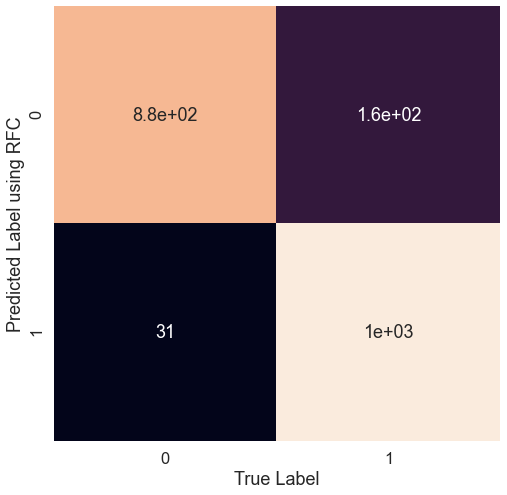

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label using RFC")
    
plot_conf_mat(y_test, y_preds)

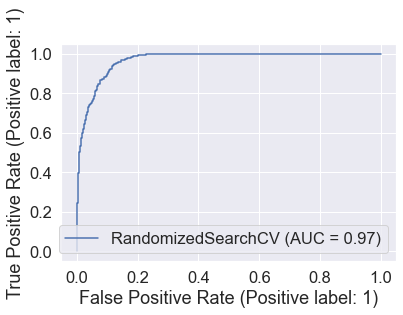

In [77]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(rs_rfc, x_test, y_test)